# Experiment 02


The current approach for creating train, validation and test data sets is to split 
the data in long-format, i.e. one observation is an intensity value from one sample representing one peptide, into the desired splits. In this process missing values are not regarded.

- [x] mask entries in larger dataset in long-format
- [x] mask peptides based on their frequency in samples (probability of being observed)
- [x] create *long-format* training data set without masked values for each model
    - FNN based on embeddings of peptides and samples (long-format **without** missing values)
    - Denoising AE (wide-format **with** missing values)
    - VAE (wide-format **with** missing values)
- [ ] restrict to only a training data split of consective data: Increase number of samples.
    - focus on best reconstruction performance
    - mean comparison

### Collaborative Filtering model

- Cannot accomodate iid assumption of statistical test in current setup for embedding vectors.
  - if pretrained model should be applied to an new batch of replicates (with a certain condition) one would need to find a way to initialize the sample embeddings without fine-tuning the model

In [1]:
import logging
from pprint import pprint
import seaborn
import numpy.testing as npt  # fastcore.test functionality

from pathlib import Path


import vaep.io_images
from vaep.pandas import interpolate
from vaep.model import build_df_from_pred_batches

from src.nb_imports import *
from src import metadata
from src.logging import setup_logger

logger = setup_logger(logger=logging.getLogger('vaep'))
logger.info("Experiment 02")

figures = {}  # collection of ax or figures

FOLDER_MQ_TXT_DATA = data\mq_out
vaep - INFO     Experiment 02


In [2]:
# None takes all
N_SAMPLES: int = 1000
n_features: int = 50
ADD_TENSORBOARD: bool = False
FN_PEPTIDE_INTENSITIES: Path = (
    config.FOLDER_DATA / 'df_intensities_N07285_M01000')  # 90%
epochs_max = 10
batch_size = 32
latent_dim = 2
most_common: bool = False
most_uncommon: bool = False
out_folder: str = 'poster'
# write to read only config ? namedtuple?

In [3]:
# Parameters
n_feat = 100
n_epochs = 10
out_folder = "runs/2D"


In [4]:
BATCH_SIZE, EPOCHS = batch_size, epochs_max
folder = Path(out_folder) / f'feat_{n_features:04d}_epochs_{epochs_max:03d}'
print(f"{folder = }")

if most_common and most_uncommon:
    raise ValueError(f"Cannot be both True: {most_common = } and {most_uncommon = }")

folder = Path('runs/2D/feat_0050_epochs_010')


## Raw data

In [5]:
FN_PEPTIDE_INTENSITIES = Path(FN_PEPTIDE_INTENSITIES)

In [6]:
analysis = AnalyzePeptides(fname=FN_PEPTIDE_INTENSITIES, nrows=None)
analysis.df.columns.name = 'peptide'
analysis.log_transform(np.log2)
analysis

AnalyzePeptides with attributes: M, N, df, index_col, is_log_transformed, is_wide_format, log_fct, stats

In [7]:
# some date are not possible in the indices
rename_indices_w_wrong_dates = {'20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_03': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_03',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_12': '20180330_QE10_nLC0_MR_QC_MNT_Hela_12',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_01': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_01',
                                '20180230_QE10_nLC0_MR_QC_MNT_Hela_11': '20180330_QE10_nLC0_MR_QC_MNT_Hela_11',
                                '20161131_LUMOS1_nLC13_AH_MNT_HeLa_long_02': '20161130_LUMOS1_nLC13_AH_MNT_HeLa_long_02'}
analysis.df.rename(index=rename_indices_w_wrong_dates, inplace=True)

### Select N consecutive samples

In [8]:
analysis.get_consecutive_dates(n_samples=N_SAMPLES)

Get 1000 samples.
Training data referenced unter: df_1000
Updated attribute: df


peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,31.517,32.278,30.832,31.541,32.803,33.676,31.927,31.906,27.631,33.747,...,31.452,28.512,29.634,31.134,30.690,30.142,29.881,31.508,29.884,29.468
20190805_QE1_nLC2_AB_MNT_HELA_01,31.104,31.747,28.999,28.458,30.588,28.800,32.415,31.270,30.077,32.357,...,29.504,29.435,28.424,29.489,29.702,29.877,28.777,30.471,27.793,29.185
20190805_QE1_nLC2_AB_MNT_HELA_02,31.248,31.923,28.643,28.257,31.068,28.864,32.340,31.672,31.636,32.466,...,29.728,29.741,28.667,29.647,29.555,29.709,28.592,30.776,27.955,29.272


In [9]:
assert not analysis.df._is_view

## Long format

- Data in long format: (peptide, sample_id, intensity)
- no missing values kept
- 

In [10]:
analysis.df_long.head()

intensity
Sample ID                           peptide                       
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AAAAAAALQAK             29.591
                                    AAFDDAIAELDTLSEESYK     31.264
                                    AAHSEGNTTAGLDMR         28.098
                                    AAVATFLQSVQVPEFTPK      28.694
                                    AAVEEGIVLGGGCALLR       30.208

In [11]:
assert analysis.df_long.isna().sum().sum(
) == 0, "There are still missing values in the long format."

In [12]:
analysis.df_wide.head()

peptide,AAAAAAALQAK,AAFDDAIAELDTLSEESYK,AAHSEGNTTAGLDMR,AAVATFLQSVQVPEFTPK,AAVEEGIVLGGGCALLR,AAVPSGASTGIYEALELR,AAVPSGASTGIYEALELRDNDK,ACANPAAGSVILLENLR,ACGLVASNLNLKPGECLR,ADLINNLGTIAK,...,VVFVFGPDK,VVFVFGPDKK,VYALPEDLVEVKPK,YADLTEDQLPSCESLK,YDDMAAAMK,YDDMAACMK,YDDMATCMK,YLAEVACGDDRK,YLDEDTIYHLQPSGR,YRVPDVLVADPPIAR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,29.591,31.264,28.098,28.694,30.208,30.134,31.358,30.430,29.440,31.035,...,29.047,27.827,27.149,28.446,29.136,28.936,27.337,28.873,27.724,28.059
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,29.817,31.354,28.132,28.508,30.171,30.189,31.311,30.412,29.410,31.034,...,28.830,27.624,27.150,28.537,28.643,29.347,27.980,29.179,27.444,28.035
20181221_QE8_nLC0_NHS_MNT_HeLa_01,29.982,31.211,24.357,28.795,29.833,28.291,32.533,31.257,30.998,32.087,...,29.325,29.346,28.907,29.588,28.434,28.369,27.397,29.143,27.233,29.432
20181222_QE9_nLC9_QC_50CM_HeLa1,29.974,30.238,28.022,28.917,30.113,30.597,31.781,30.620,27.377,31.457,...,29.409,27.696,27.622,29.104,28.151,29.017,27.815,29.317,28.027,28.516
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,29.552,31.966,28.165,29.985,31.660,31.787,31.915,31.792,30.077,31.479,...,29.341,NaN,27.327,29.091,29.422,29.057,26.068,29.129,27.474,28.216


In [13]:
assert analysis.df_wide.isna().sum().sum(
) > 0, "There are no missing values left in the wide format"

### Sampling peptides by their frequency (important for later)

- higher count, higher probability to be sampled into training data
- missing peptides are sampled both into training as well as into validation dataset
- everything not in training data is validation data

In [14]:
# freq_per_peptide = analysis.df.unstack().to_frame('intensity').reset_index(1, drop=True)
freq_per_peptide = analysis.df_long['intensity']
freq_per_peptide = freq_per_peptide.notna().groupby(level=1).sum()
print(f"{n_features = }")


n_features = 50


### Selecting N
 - most common
 - most uncommon

In [15]:
freq_per_pepitde = freq_per_peptide.sort_values(ascending=False)

if most_common:
    freq_per_pepitde = freq_per_pepitde.iloc[:n_features]
elif most_uncommon:
    freq_per_pepitde = freq_per_pepitde.iloc[-n_features:]
else:
    freq_per_pepitde = freq_per_pepitde.sample(n_features)
    
assert len(freq_per_pepitde.index) == n_features

freq_per_pepitde

peptide
AIDDNMSLDEIEK                   968
FAQPGSFEYEYAMR                  961
TLTAVHDAILEDLVFPSEIVGK          960
ITLQDVVSHSK                     992
VEFMDDTSR                       981
RAGELTEDEVER                    993
FNEEHIPDSPFVVPVASPSGDAR         981
ALTSEIALLQSR                    995
AHGPGLEGGLVGKPAEFTIDTK          964
IVEVLLMK                        993
EQIVPKPEEEVAQK                  993
VVSQYSSLLSPMSVNAVMK             997
AQIHDLVLVGGSTR                  981
SGDSEVYQLGDVSQK                 970
VLAMSGDPNYLHR                   974
VFITDDFHDMMPK                   994
GYISPYFINTSK                    971
ILQDGGLQVVEK                    992
EGHLSPDIVAEQK                   996
LDPHLVLDQLR                     990
NMMAACDPR                       997
IGLFGGAGVGK                     960
GLVLGPIHK                       986
HEQILVLDPPTDLK                  981
NIDNPALADIYTEHAHQVVVAK          991
ELAEDGYSGVEVR                   999
ARFEELCSDLFR                    997
TAFQEALDAAGDK       

In [16]:
analysis.df = analysis.df[freq_per_pepitde.index]
# ToDo: clean-up other attributes needs to be integrated
del analysis._df_long  # , analysis._df_wide
analysis.df_long

intensity
Sample ID                           peptide                               
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AIDDNMSLDEIEK                   26.945
                                    FAQPGSFEYEYAMR                  27.780
                                    TLTAVHDAILEDLVFPSEIVGK          30.168
                                    ITLQDVVSHSK                     27.466
                                    VEFMDDTSR                       28.817
...                                                                    ...
20190805_QE1_nLC2_AB_MNT_HELA_04    IAGYVTHLMK                      30.712
                                    KIEPELDGSAQVTSHDASTNGLINFIK     30.358
                                    EEASDYLELDTIK                   29.041
                                    VEPGLGADNSVVR                   29.902
                                    THEAQIQEMR                      29.699

[49112 rows x 1 columns]

- biological stock differences in PCA plot. Show differences in models. Only see biological variance

## PCA plot of raw data

vaep - ERROR    Could not find LC instrument in 20190418_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190422_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190425_QX8_JuSc_MA_HeLa_500ng_1


vaep - ERROR    Could not find LC instrument in 20190501_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190502_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190506_QX7_ChDe_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_new


vaep - ERROR    Could not find LC instrument in 20190506_QX8_MiWi_MA_HeLa_500ng_old


vaep - ERROR    Could not find LC instrument in 20190514_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190520_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190521_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190524_QX4_JoSw_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190526_QX4_LiSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190527_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190530_QX4_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190603_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190606_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190607_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190611_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190615_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190617_QX8_IgPa_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190618125902


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_190619010035


vaep - ERROR    Could not find LC instrument in 20190618_QX4_JiYu_MA_HeLa_500ng_centroid


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190621_QX4_JoMu_MA_HeLa_500ng_190621161214


vaep - ERROR    Could not find LC instrument in 20190624_QX4_JiYu_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190629_QX4_JiYu_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190701_QX4_MePh_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190703_QX4_MaTa_MA_HeLa_500ng_MAX_ALLOWED


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190706_QX4_MiWi_MA_HeLa_500ng_190707003046


vaep - ERROR    Could not find LC instrument in 20190717_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190718_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190719_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX4_StEb_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190722_QX8_ChSc_MA_HeLa_500ng_190722174431


vaep - ERROR    Could not find LC instrument in 20190725_QX2_MePh_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190726_QX8_ChSc_MA_HeLa_500ng


vaep - ERROR    Could not find LC instrument in 20190731_QX8_ChSc_MA_HeLa_500ng


Created metadata DataFrame attribute `df_meta`.
Added proportion of not NA values based on `df` intensities.


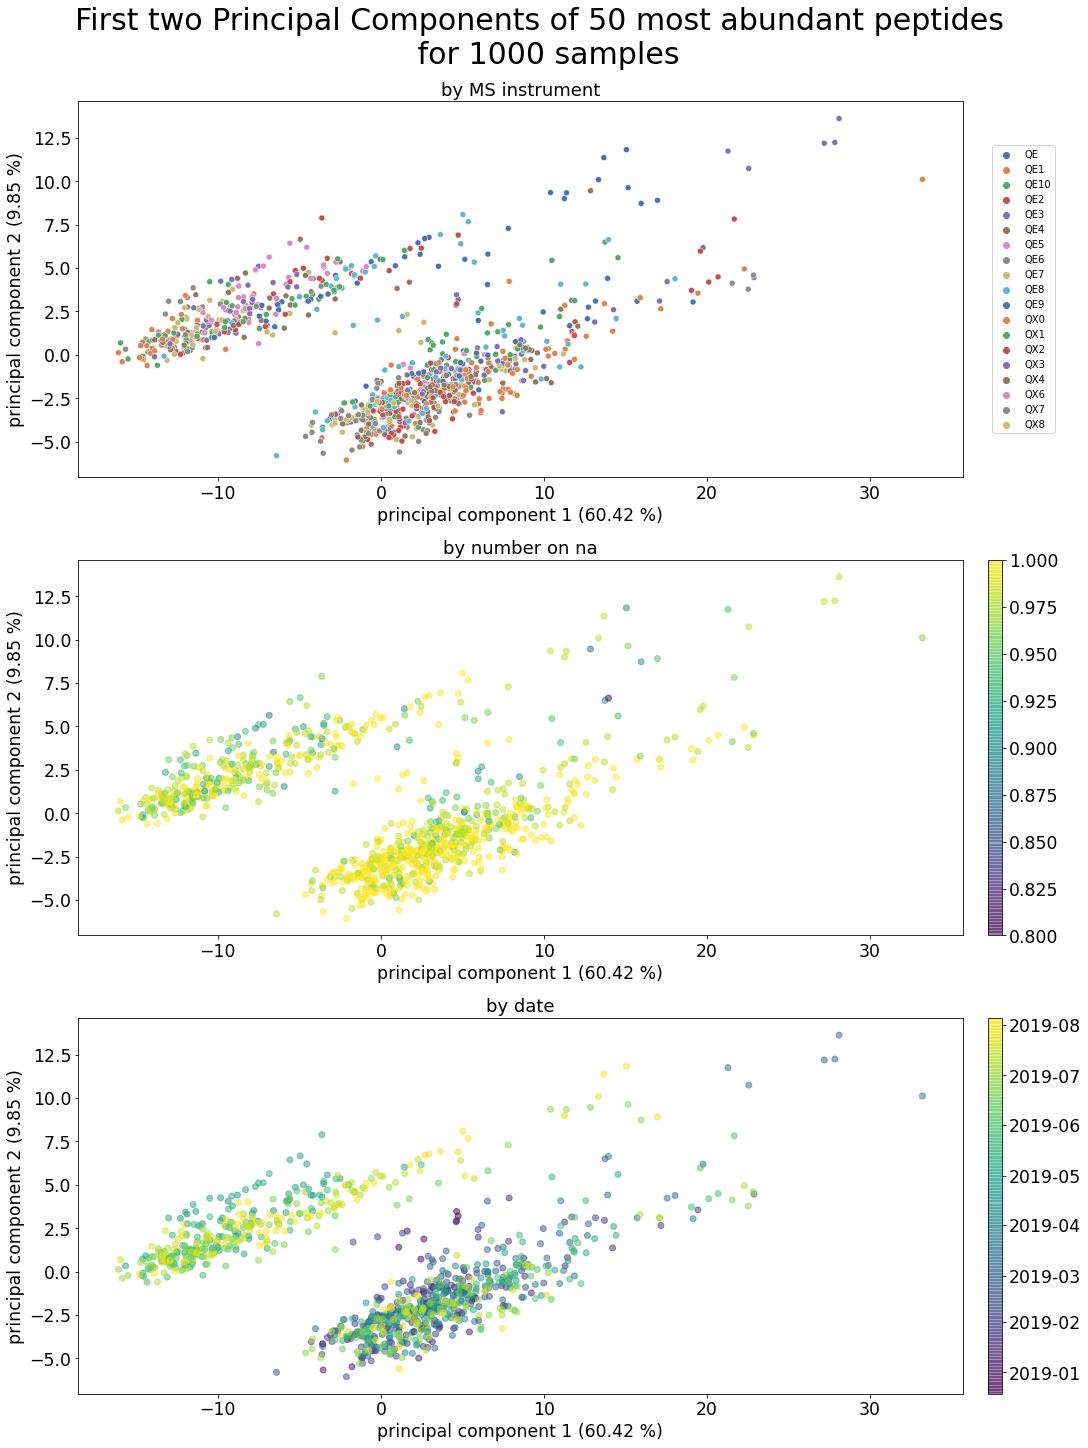

In [17]:
fig = analysis.plot_pca()

In [18]:
# ToDo add df_meta property
analysis.df_meta.describe()

,prop_not_na
count,"1,000.000"
mean,0.982
std,0.024
min,0.800
25%,0.980
50%,0.990
75%,1.000
max,1.000


In [19]:
vaep.io_images._savefig(fig, folder /
                        f'pca_plot_raw_data_{analysis.fname_stub}')

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\pca_plot_raw_data_N01000_M00050


## Train and Validation data

- use mulitindex for obtaining validation split

In [20]:
# analysis._df_long = analysis.df_long.reset_index(
# ).set_index(['Sample ID', 'peptide'])
analysis.df_long

intensity
Sample ID                           peptide                               
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 AIDDNMSLDEIEK                   26.945
                                    FAQPGSFEYEYAMR                  27.780
                                    TLTAVHDAILEDLVFPSEIVGK          30.168
                                    ITLQDVVSHSK                     27.466
                                    VEFMDDTSR                       28.817
...                                                                    ...
20190805_QE1_nLC2_AB_MNT_HELA_04    IAGYVTHLMK                      30.712
                                    KIEPELDGSAQVTSHDASTNGLINFIK     30.358
                                    EEASDYLELDTIK                   29.041
                                    VEPGLGADNSVVR                   29.902
                                    THEAQIQEMR                      29.699

[49112 rows x 1 columns]

In [21]:
# df_long = analysis.df.unstack().to_frame('intensity').reset_index(1)
analysis.df_train = analysis.df_long.reset_index(0).groupby(
    by='Sample ID',
    level=0
).sample(frac=0.90,
         weights=freq_per_peptide,
         random_state=42)
analysis.df_train = analysis.df_train.reset_index().set_index([
    'Sample ID', 'peptide'])
analysis.df_train

,,intensity
Sample ID,peptide,
20190411_QE6_LC6_AS_QC_MNT_HeLa_02,ADEGISFR,31.443
20190730_QE6_nLC4_MPL_QC_MNT_HeLa_01,ADEGISFR,32.155
20190624_QE6_LC4_AS_QC_MNT_HeLa_02,ADEGISFR,26.847
20190528_QX1_PhGe_MA_HeLa_DMSO_500ng_LC14_190528164924,ADEGISFR,33.451
20190208_QE2_NLC1_AB_QC_MNT_HELA_3,ADEGISFR,32.090
...,...,...
20190803_QE8_nLC14_ASD_QC_MNT_HeLa,YMACCLLYR,28.626
20190724_QX0_MePh_MA_HeLa_500ng_LC07_01,YMACCLLYR,31.556
20190204_QE8_nLC14_RG_QC_HeLa_15cm_02,YMACCLLYR,29.894


In [22]:
analysis.indices_valid = analysis.df_long.index.difference(
    analysis.df_train.index)
analysis.df_valid = analysis.df_long.loc[analysis.indices_valid]

In [23]:
assert len(analysis.df_long) == len(analysis.df_train) + len(analysis.df_valid)

Check that all samples are also in the validation data

In [24]:
assert analysis.df_train.index.levshape == (N_SAMPLES, n_features)

try:
    assert analysis.df_valid.index.levshape == (N_SAMPLES, n_features)
except AssertionError:
    print(f'Expected shape in validation: {(N_SAMPLES, n_features)}')
    print(f'Shape in validation: {analysis.df_valid.index.levshape}')

analysis.df_train = analysis.df_train.loc[analysis.df_valid.index.levels[0]]
analysis.df_train = analysis.df_train.reset_index().set_index(
    ['Sample ID', 'peptide'])  # update index categories (there is probably a better way)
N_SAMPLES = analysis.df_valid.index.levshape[0]
analysis.df_train.index.levshape, analysis.df_valid.index.levshape

Expected shape in validation: (1000, 50)
Shape in validation: (994, 50)


((994, 50), (994, 50))

## Setup DL

- [ ] move all above to separate data notebook

In [25]:
import vaep.models as models
from vaep.models.cmd import get_args
from vaep.models import ae

args = get_args(batch_size=BATCH_SIZE, epochs=EPOCHS,
                no_cuda=False)  # data transfer to GPU seems slow
kwargs = {'num_workers': 2, 'pin_memory': True} if args.cuda else {}

# torch.manual_seed(args.seed)
device = torch.device("cuda" if args.cuda else "cpu")
device

print(f"{args = }", f"{device = }", sep='\n')

args = Namespace(batch_size=32, cuda=True, epochs=10, log_interval=10, no_cuda=False, seed=43)
device = device(type='cuda')


Fastai default device for computation

In [26]:
import fastai.torch_core
print(f"{torch.cuda.is_available() = }")  # self-documenting python 3.8
fastai.torch_core.defaults

torch.cuda.is_available() = True


namespace(cpus=12,
          use_cuda=None,
          activation=torch.nn.modules.activation.ReLU,
          callbacks=[fastai.callback.core.TrainEvalCallback,
                     fastai.learner.Recorder,
                     fastai.callback.progress.ProgressCallback],
          lr=0.001)

### Comparison data

- first impute first and last row (using n=3 replicate)
- use pandas interpolate

In [27]:
analysis.median_train = analysis.df_train['intensity'].unstack().median()
analysis.median_train.name = 'train_median'
analysis.averag_train = analysis.df_train['intensity'].unstack().mean()
analysis.averag_train.name = 'train_average'

df_pred = analysis.df_valid.copy()

df_pred = df_pred.join(analysis.median_train, on='peptide')
df_pred = df_pred.join(analysis.averag_train, on='peptide')


_ = interpolate(wide_df=analysis.df_train['intensity'].unstack())
df_pred = df_pred.join(_)

df_pred

intensity  \
Sample ID                           peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                        30.461   
                                    ALTSEIALLQSR                    27.244   
                                    EGNDLYHEMIESGVINLK              27.597   
                                    TLTAVHDAILEDLVFPSEIVGK          30.168   
                                    VLAMSGDPNYLHR                   27.667   
...                                                                    ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR               28.390   
                                    HIYYITGETK                      30.932   
                                    IHVSDQELQSANASVDDSRLEELK        28.929   
                                    KIEPELDGSAQVTSHDASTNGLINFIK     30.358   
                                    NMMAACDPR                       32.531   

                                                                 train_median  \
Sample ID                           peptide                                     
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                           31.743   
                                    ALTSEIALLQSR                       28.492   
                                    EGNDLYHEMIESGVINLK                 28.637   
                                    TLTAVHDAILEDLVFPSEIVGK             30.036   
                                    VLAMSGDPNYLHR                      28.729   
...                                                                       ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                  28.837   
                                    HIYYITGETK                         30.755   
                                    IHVSDQELQSANASVDDSRLEELK           28.922   
                                    KIEPELDGSAQVTSHDASTNGLINFIK        30.012   
                                    NMMAACDPR                          32.091   

                                                                 train_average  \
Sample ID                           peptide                                      
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                            31.775   
                                    ALTSEIALLQSR                        28.482   
                                    EGNDLYHEMIESGVINLK                  28.841   
                                    TLTAVHDAILEDLVFPSEIVGK              29.682   
                                    VLAMSGDPNYLHR                       28.549   
...                                                                        ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                   28.853   
                                    HIYYITGETK                          30.692   
                                    IHVSDQELQSANASVDDSRLEELK            29.252   
                                    KIEPELDGSAQVTSHDASTNGLINFIK         29.913   
                                    NMMAACDPR                           32.015   

                                                                 replicates  
Sample ID                           peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                         31.118  
                                    ALTSEIALLQSR                     27.467  
                                    EGNDLYHEMIESGVINLK               27.366  
                                    TLTAVHDAILEDLVFPSEIVGK           29.769  
                                    VLAMSGDPNYLHR                    27.706  
...                                                                     ...  
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                28.490  
                                    HIYYITGETK                       30.868  
                                    IHVSDQELQSANASVDDSRLEELK         29.313  
                                    KIEPELDGSAQVTSHDASTNGLINFIK      30

In [28]:
if any(df_pred.isna()):
    print("Consecutive NaNs are not imputed using replicates.")
    display(df_pred.loc[df_pred.isna().any(axis=1)])

Consecutive NaNs are not imputed using replicates.


,,intensity,train_median,train_average,replicates
Sample ID,peptide,,,,
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,ALTSEIALLQSR,27.441,28.492,28.482,NaN
20181227_QE6_nLC6_CSC_QC_HeLa_02,SGDSEVYQLGDVSQK,28.562,27.819,28.079,NaN
20181228_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-007,ELAEDGYSGVEVR,29.437,29.305,29.527,NaN
20190115_QE2_NLC10_TW_QC_MNT_HeLa_01,ITLQDVVSHSK,27.326,28.156,28.136,NaN
20190115_QE5_nLC5_RJC_MNT_HeLa_01,YMACCLLYR,29.433,29.193,29.171,NaN
20190129_QE1_nLC2_GP_QC_MNT_HELA_01,EQIVPKPEEEVAQK,29.390,30.085,30.309,NaN
20190131_QE10_nLC0_NHS_MNT_HELA_50cm_02,FAQPGSFEYEYAMR,25.513,26.295,26.916,NaN
20190201_QE10_nLC0_NHS_MNT_HELA_45cm_01,FLSQPFQVAEVFTGHMGK,30.397,31.597,31.237,NaN
20190203_QE3_nLC3_KBE_QC_MNT_HeLa_01,GYISPYFINTSK,28.945,29.545,29.954,NaN


## Collaboritive filtering model

In [29]:
from fastai.collab import CollabDataLoaders, MSELossFlat, Learner
from fastai.collab import EmbeddingDotBias

analysis.collab = Analysis()
collab = analysis.collab
collab.columns = 'peptide,Sample ID,intensity'.split(',')

Create data view for collaborative filtering

- currently a bit hacky as the splitter does not support predefinded indices (create custum subclass providing splits to internal methods?)

- Use the [`CollabDataLoaders`](https://docs.fast.ai/collab.html#CollabDataLoaders)  similar to the [`TabularDataLoaders`](https://docs.fast.ai/tabular.data.html#TabularDataLoaders).
- Use the [`IndexSplitter`](https://docs.fast.ai/data.transforms.html#IndexSplitter) and provide splits to whatever is used in `CollabDataLoaders`


In [30]:
collab.df_train = analysis.df_train.reset_index()
collab.df_valid = analysis.df_valid.reset_index()
collab.df_train.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AFGYYGPLR,28.703
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AHGPGLEGGLVGKPAEFTIDTK,27.649
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AIDDNMSLDEIEK,26.945
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,AQIHDLVLVGGSTR,29.171
4,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ARFEELCSDLFR,28.689


In [31]:
collab.df_valid.head()

,Sample ID,peptide,intensity
0,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ADEGISFR,30.461
1,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,ALTSEIALLQSR,27.244
2,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,EGNDLYHEMIESGVINLK,27.597
3,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,TLTAVHDAILEDLVFPSEIVGK,30.168
4,20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,VLAMSGDPNYLHR,27.667


In [32]:
assert (collab.df_train.intensity.isna().sum(),
        collab.df_valid.intensity.isna().sum()) == (0, 0), "Remove missing values."

Hacky part uses training data `Datasets` from dataloaders to recreate a custom `DataLoaders` instance

In [33]:
collab.dl_train = CollabDataLoaders.from_df(
    collab.df_train, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size, device=device)
collab.dl_valid = CollabDataLoaders.from_df(
    collab.df_valid, valid_pct=0.0, user_name='Sample ID', item_name='peptide', rating_name='intensity', bs=args.batch_size,
    shuffle=False, device=device)
collab.dl_train.show_batch()

,Sample ID,peptide,intensity
0,20190208_QE3_nLC3_KBE_QC_MNT_HeLa_01,EEASDYLELDTIK,28.406
1,20190719_QX1_JoMu_MA_HeLa_500ng_LC10,IVEVLLMK,29.830
2,20190515_QE4_LC12_AS_QC_MNT_HeLa_01,FLSQPFQVAEVFTGHMGK,32.412
3,20190709_QE3_nLC5_GF_QC_MNT_Hela_02,KIEPELDGSAQVTSHDASTNGLINFIK,29.837
4,20190731_QE8_nLC14_ASD_QC_MNT_HeLa_02,NTGIICTIGPASR,31.336
5,20190425_QX8_JuSc_MA_HeLa_500ng_1,ARFEELCSDLFR,29.537
6,20190723_QE4_LC12_IAH_QC_MNT_HeLa_03,THEAQIQEMR,29.049
7,20190802_QE3_nLC3_DBJ_AMV_QC_MNT_HELA_02,GLVLGPIHK,29.302
8,20190425_QX4_JoSw_MA_HeLa_500ng_BR13_standard_190425181909,FVINYDYPNSSEDYIHR,31.340
9,20190609_QX8_MiWi_MA_HeLa_BR14_500ng_190625163359,FLSQPFQVAEVFTGHMGK,31.984


In [34]:
from fastai.data.core import DataLoaders
collab.dls = DataLoaders(collab.dl_train.train, collab.dl_valid.train)
if args.cuda:
    collab.dls.cuda()

In [35]:
collab.dl_valid.show_batch()

,Sample ID,peptide,intensity
0,20190717_QX3_OzKa_MA_Hela_500ng_LC15_190721144939,ALTSEIALLQSR,30.092
1,20190121_QE5_nLC5_AH_QC_MNT_HeLa_250ng_01,NTGIICTIGPASR,31.225
2,20190625_QE1_nLC2_GP_QC_MNT_HELA_03,THEAQIQEMR,30.063
3,20190702_QE10_nLC0_FaCo_QC_MNT_HeLa_MUC,TFVNITPAEVGVLVGK,33.509
4,20190719_QE1_nLC13_GP_QC_MNT_HELA_01,FAQPGSFEYEYAMR,23.897
5,20190213_QE3_nLC3_UH_QC_MNT_HeLa_02,ALTSEIALLQSR,27.276
6,20190624_QX4_JiYu_MA_HeLa_500ng,FVINYDYPNSSEDYIHR,29.791
7,20190129_QE8_nLC14_FaCo_QC_MNT_50cm_Hela_20190129205246,TFVNITPAEVGVLVGK,33.786
8,20190624_QE4_nLC12_MM_QC_MNT_HELA_01_20190625144904,DSTLIMQLLR,32.149
9,20190611_QE4_LC12_JE_QC_MNT_HeLa_01,EGHLSPDIVAEQK,29.666


In [36]:
len(collab.dls.classes['Sample ID']), len(collab.dls.classes['peptide'])

(995, 51)

In [37]:
len(collab.dls.train), len(collab.dls.valid)  # mini-batches

(1372, 154)

Alternatively to the hacky version, one could use a factory method, but there the sampling/Splitting methods would need to be implemented (not using [`RandomSplitter`](https://docs.fast.ai/data.transforms.html#RandomSplitter) somehow)

 - [`TabDataLoader`](https://docs.fast.ai/tabular.core.html#TabDataLoader)
 - uses [`TabularPandas`](https://docs.fast.ai/tabular.core.html#TabularPandas)
 
 > Current problem: No custom splitter can be provided

### Model

In [38]:
collab.model_args = {}
collab.model_args['n_samples'] = len(collab.dls.classes['Sample ID'])
collab.model_args['n_peptides'] = len(collab.dls.classes['peptide'])
collab.model_args['dim_latent_factors'] = latent_dim
collab.model_args['y_range'] = (
    int(analysis.df_train['intensity'].min()), int(analysis.df_train['intensity'].max())+1)

print("Args:")
pprint(collab.model_args)


# from vaep.models.collab import DotProductBias
# model = DotProductBias(**collab.model_args)
model = EmbeddingDotBias.from_classes(
    n_factors=collab.model_args['dim_latent_factors'], classes=collab.dls.classes, y_range=collab.model_args['y_range'])
learn = Learner(dls=collab.dls, model=model, loss_func=MSELossFlat())
if args.cuda:
    learn.cuda()
learn.summary()

Args:
{'dim_latent_factors': 2,
 'n_peptides': 51,
 'n_samples': 995,
 'y_range': (20, 35)}


EmbeddingDotBias (Input shape: 32 x 2)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 2              
Embedding                                 1990       True      
Embedding                                 102        True      
____________________________________________________________________________
                     32 x 1              
Embedding                                 995        True      
Embedding                                 51         True      
____________________________________________________________________________

Total params: 3,138
Total trainable params: 3,138
Total non-trainable params: 0

Optimizer used: <function Adam at 0x00000297F9587040>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

### Training

In [39]:
learn.fit_one_cycle(epochs_max, 5e-3)

epoch,train_loss,valid_loss,time
0,2.378061,2.036471,00:08
1,0.853891,0.877336,00:08
2,0.714594,0.739279,00:08
3,0.667353,0.702194,00:08
4,0.612311,0.687951,00:08
5,0.590427,0.661613,00:08
6,0.570451,0.656601,00:08
7,0.594977,0.650413,00:08
8,0.558643,0.649032,00:08
9,0.510968,0.648707,00:08


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_training


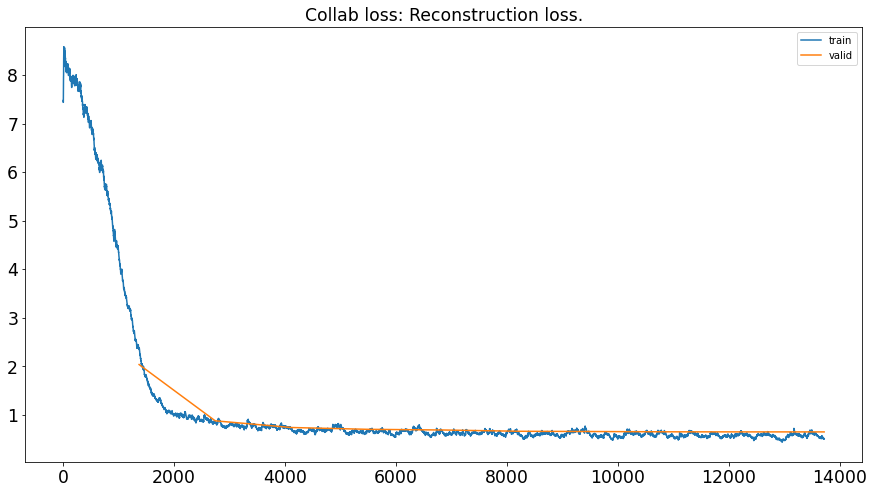

In [40]:
from vaep.models import plot_loss
from fastai import learner
learner.Recorder.plot_loss = plot_loss

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('Collab loss: Reconstruction loss.')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='collab_training',
                        folder=folder)

### Evaluation

In [41]:
collab.dls.valid_ds.items

,Sample ID,peptide,intensity
"4,366",885,5,30.092
350,74,36,31.225
"3,594",734,42,30.063
"3,925",798,41,33.509
"4,393",891,15,23.897
...,...,...,...
"2,606",531,27,29.648
"3,901",794,35,33.233
925,192,5,27.273
126,27,10,27.762


In [42]:
df_pred = df_pred.reset_index()
pred, target = learn.get_preds()
df_pred['intensity_pred_collab'] = pd.Series(
    pred.flatten().numpy(), index=collab.dls.valid.items.index)

npt.assert_almost_equal(
    actual=collab.dls.valid.items.intensity.to_numpy(),
    desired=target.numpy().flatten()
)


df_pred = analyzers.cast_object_to_category(df_pred)
df_pred.set_index(['Sample ID', 'peptide'], inplace=True)
df_pred

intensity  \
Sample ID                           peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                        30.461   
                                    ALTSEIALLQSR                    27.244   
                                    EGNDLYHEMIESGVINLK              27.597   
                                    TLTAVHDAILEDLVFPSEIVGK          30.168   
                                    VLAMSGDPNYLHR                   27.667   
...                                                                    ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR               28.390   
                                    HIYYITGETK                      30.932   
                                    IHVSDQELQSANASVDDSRLEELK        28.929   
                                    KIEPELDGSAQVTSHDASTNGLINFIK     30.358   
                                    NMMAACDPR                       32.531   

                                                                 train_median  \
Sample ID                           peptide                                     
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                           31.743   
                                    ALTSEIALLQSR                       28.492   
                                    EGNDLYHEMIESGVINLK                 28.637   
                                    TLTAVHDAILEDLVFPSEIVGK             30.036   
                                    VLAMSGDPNYLHR                      28.729   
...                                                                       ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                  28.837   
                                    HIYYITGETK                         30.755   
                                    IHVSDQELQSANASVDDSRLEELK           28.922   
                                    KIEPELDGSAQVTSHDASTNGLINFIK        30.012   
                                    NMMAACDPR                          32.091   

                                                                 train_average  \
Sample ID                           peptide                                      
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                            31.775   
                                    ALTSEIALLQSR                        28.482   
                                    EGNDLYHEMIESGVINLK                  28.841   
                                    TLTAVHDAILEDLVFPSEIVGK              29.682   
                                    VLAMSGDPNYLHR                       28.549   
...                                                                        ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                   28.853   
                                    HIYYITGETK                          30.692   
                                    IHVSDQELQSANASVDDSRLEELK            29.252   
                                    KIEPELDGSAQVTSHDASTNGLINFIK         29.913   
                                    NMMAACDPR                           32.015   

                                                                 replicates  \
Sample ID                           peptide                                   
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                         31.118   
                                    ALTSEIALLQSR                     27.467   
                                    EGNDLYHEMIESGVINLK               27.366   
                                    TLTAVHDAILEDLVFPSEIVGK           29.769   
                                    VLAMSGDPNYLHR                    27.706   
...                                                                     ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                28.490   
                                    HIYYITGETK                       30.868   
                                    IHVSDQELQSANASVDDSRLEELK         29.313   
                                    KIEPELDGSAQVTSHDASTNGLIN

In [43]:
assert (abs(target.reshape(-1) - pred.reshape(-1))).sum() / len(target) - \
    (df_pred.intensity - df_pred.intensity_pred_collab).abs().sum() / \
    len(df_pred) < 0.00001

### Plot biases and embedding weigths

- visualize relative order of samples and peptides

In [44]:
from collections import namedtuple
def get_bias(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.bias(indices.values, is_item=is_item) # user=sample
    return pd.Series(ret, index=indices)

# def get_weigths

CollabIDs = namedtuple("CollabIDs", "sample peptide")

collab.biases = CollabIDs(
    sample=get_bias(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_bias(learn, indices=analysis.df_train.index.levels[1] )
)
collab.biases.sample.head()

Sample ID
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02     0.132
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01    0.133
20181221_QE8_nLC0_NHS_MNT_HeLa_01       0.270
20181222_QE9_nLC9_QC_50CM_HeLa1         0.173
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01   0.158
dtype: float32

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_samples


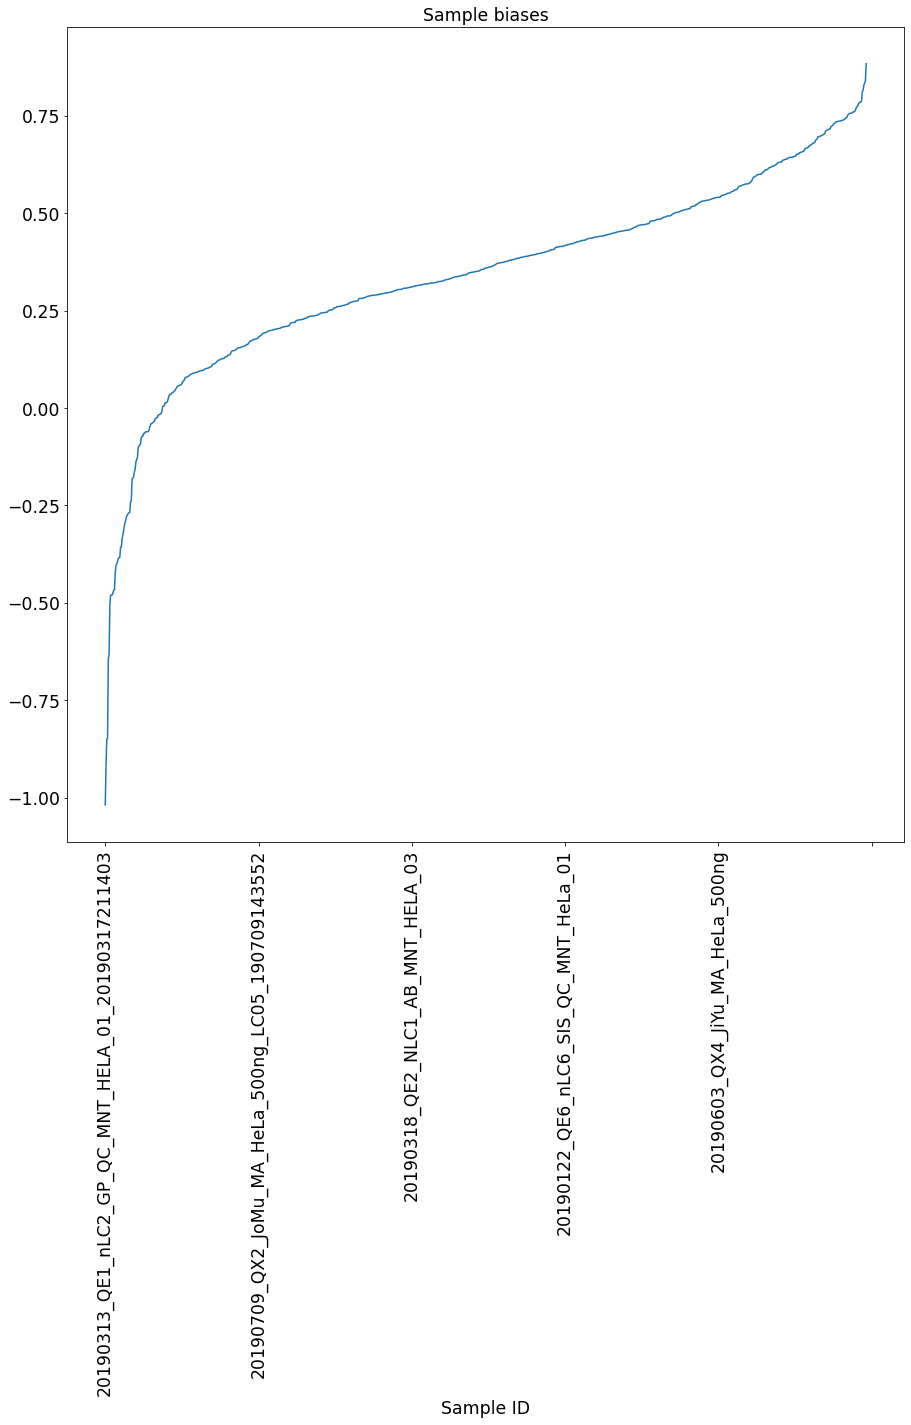

In [45]:
fig, ax = plt.subplots(figsize=(15, 15))
ax = collab.biases.sample.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_samples',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_bias_peptides


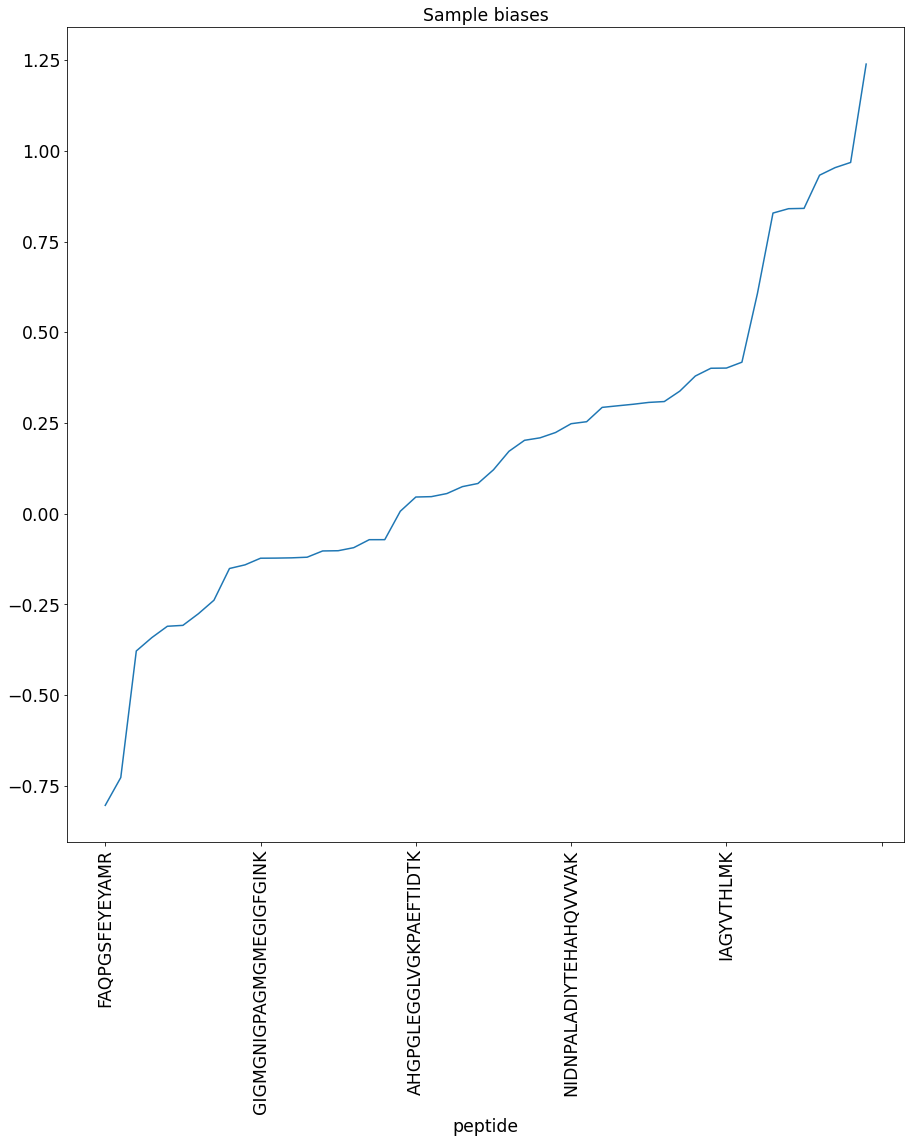

In [46]:
fig, ax = plt.subplots(figsize=(15, 15))
_ = collab.biases.peptide.sort_values().plot(kind='line', rot=90, title='Sample biases', ax=ax)
vaep.io_images._savefig(fig, name='collab_bias_peptides',
                        folder=folder)

In [47]:
def get_weight(learner, indices, is_item=True) -> pd.Series:
    ret = learner.model.weight(indices.values, is_item=is_item) # user=sample
    return pd.DataFrame(ret, index=indices, columns=[f'latent dimension {i+1}' for i in range(ret.shape[-1])])

collab.embeddings = CollabIDs(
    sample=get_weight(learn, indices=analysis.df_train.index.levels[0], is_item=False), # item=peptide
    peptide=get_weight(learn, indices=analysis.df_train.index.levels[1] )
)
collab.embeddings.sample.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.157,-0.079
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.198,-0.069
20181221_QE8_nLC0_NHS_MNT_HeLa_01,0.004,0.005
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.185,0.064
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.193,-0.341


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_date


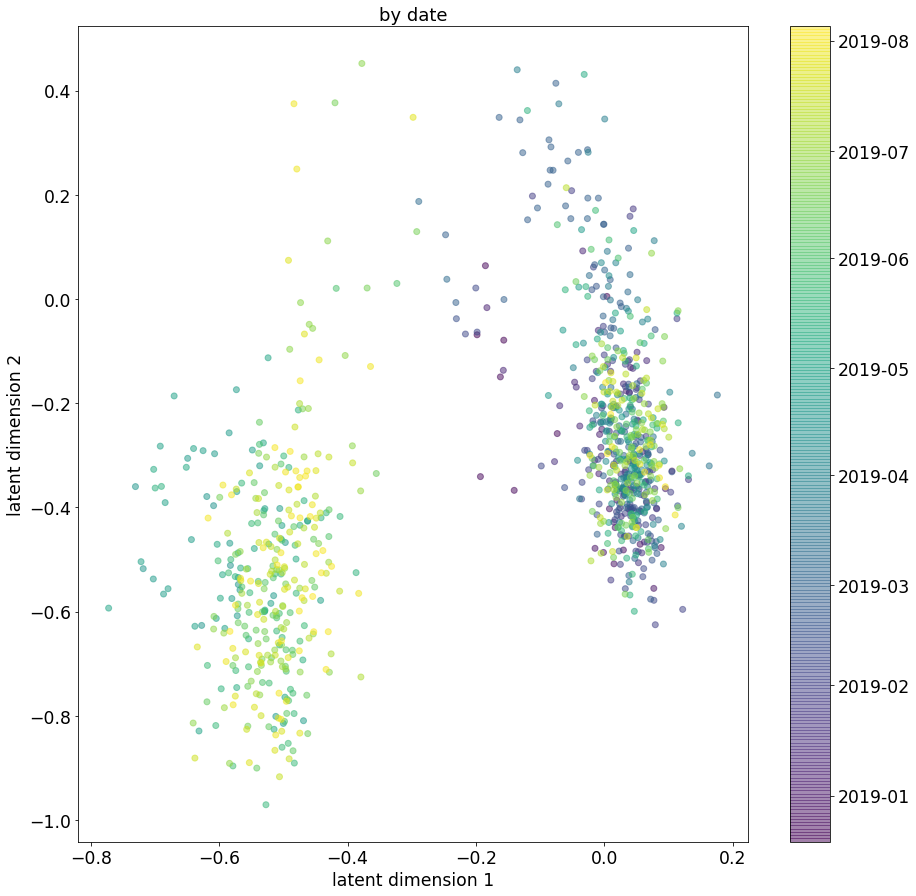

In [48]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=collab.embeddings.sample, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[collab.embeddings.sample.index])
vaep.io_images._savefig(fig, name='collab_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\collab_latent_by_ms_instrument


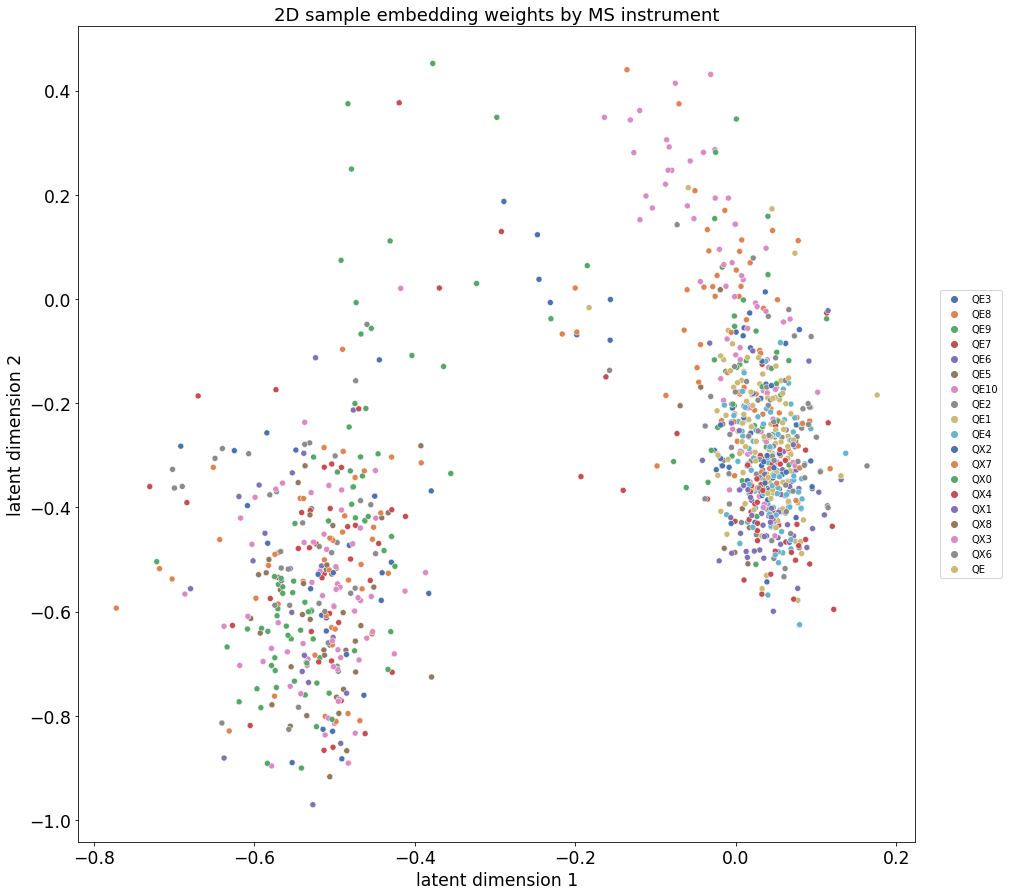

In [49]:
fig, ax = plt.subplots(figsize=(15, 15))
meta_col = 'ms_instrument'

df_ = collab.embeddings.sample
analyzers.seaborn_scatter(df=df_,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_.index],
                          title='2D sample embedding weights by MS instrument')

vaep.io_images._savefig(fig, name='collab_latent_by_ms_instrument',
                        folder=folder)

## Denoising Autoencoder (DAE)

### Custom Transforms

- [x] Shift standard normalized data around
    - Error metrics won't be directly comparable afterwards

In [50]:
from fastai.tabular.all import *
from vaep.models import ae

from fastai.tabular.core import TabularPandas

# from fastai.callback.core import Callback

from fastai.data.core import DataLoaders

from fastai.learner import Learner
from fastai.losses import MSELossFlat


# https://docs.fast.ai/tabular.core.html#FillStrategy
# from fastai.tabular.core import FillMissing
# from fastai.tabular.core import TabularPandas

### DataLoaders

In [51]:
# revert format
# undo using `stack`
analysis.df_train = analysis.df_train['intensity'].unstack()
analysis.df_valid = analysis.df_valid['intensity'].unstack()
analysis.df_valid.head()

peptide,ADEGISFR,AFGYYGPLR,AHGPGLEGGLVGKPAEFTIDTK,AIDDNMSLDEIEK,ALTSEIALLQSR,AQIHDLVLVGGSTR,ARFEELCSDLFR,DSTLIMQLLR,EEASDYLELDTIK,EGHLSPDIVAEQK,...,TFVNITPAEVGVLVGK,THEAQIQEMR,TLTAVHDAILEDLVFPSEIVGK,TVAGGAWTYNTTSAVTVK,VEFMDDTSR,VEPGLGADNSVVR,VFITDDFHDMMPK,VLAMSGDPNYLHR,VVSQYSSLLSPMSVNAVMK,YMACCLLYR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,30.461,NaN,NaN,NaN,27.244,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.168,NaN,NaN,NaN,NaN,27.667,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,28.705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.391
20181221_QE8_nLC0_NHS_MNT_HeLa_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,NaN,NaN,NaN,29.147,27.471,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,27.441,28.800,NaN,NaN,28.640,NaN,...,NaN,NaN,NaN,NaN,NaN,29.330,NaN,NaN,NaN,NaN


Mean and std. dev. from training data

In [52]:
# norm = Normalize.from_stats(analysis.df_train.mean(), analysis.df_valid.std()) # copy interface?
NORMALIZER = Normalize  # dae.NormalizeShiftedMean

#### Training data

procs passed to TabluarPandas are handled internally 
  1. not necessarily in order
  2. with setup call (using current training data)

In [53]:
procs = [NORMALIZER, FillMissing(add_col=True)]
cont_names = list(analysis.df_train.columns)

to = TabularPandas(analysis.df_train, procs=procs, cont_names=cont_names)
print("Tabular object:", type(to))

to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,ADEGISFR,AFGYYGPLR,AHGPGLEGGLVGKPAEFTIDTK,AIDDNMSLDEIEK,ALTSEIALLQSR,AQIHDLVLVGGSTR,ARFEELCSDLFR,DSTLIMQLLR,EEASDYLELDTIK,EGHLSPDIVAEQK,...,TFVNITPAEVGVLVGK_na,THEAQIQEMR_na,TLTAVHDAILEDLVFPSEIVGK_na,TVAGGAWTYNTTSAVTVK_na,VEFMDDTSR_na,VEPGLGADNSVVR_na,VFITDDFHDMMPK_na,VLAMSGDPNYLHR_na,VVSQYSSLLSPMSVNAVMK_na,YMACCLLYR_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.027,-0.935,-0.835,-1.365,0.007,-0.091,-1.265,-0.197,-0.576,-1.207,...,False,False,True,False,False,False,False,True,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.969,-0.069,-0.769,-0.338,-1.233,-0.041,-0.821,-0.087,-0.524,-1.085,...,False,False,False,False,False,False,False,False,False,True
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.251,-0.558,-0.168,-0.498,-0.488,-0.283,-0.918,-0.367,-0.004,-0.039,...,False,False,False,False,False,False,False,False,False,False
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.650,-0.776,-1.038,-0.017,0.007,0.328,-0.580,-0.088,-0.569,-0.519,...,False,False,False,False,False,False,False,False,False,False
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.867,-1.120,-0.776,-0.285,0.007,-0.099,-0.961,0.796,0.087,-1.180,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,0.332,0.487,-0.581,0.916,0.634,1.130,0.649,0.990,0.087,0.198,...,False,False,False,False,False,True,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_01,0.299,-0.004,0.380,-0.264,-0.192,0.036,-0.244,-1.920,0.069,0.276,...,True,False,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_02,0.094,-0.069,0.441,-0.062,-0.175,0.219,0.120,0.271,0.129,0.364,...,False,False,False,False,False,False,False,False,False,False


Better manuelly apply `Transforms` on `Tabluar` type

In [54]:
cont_names = list(analysis.df_train.columns)
to = TabularPandas(analysis.df_train, cont_names=cont_names, do_setup=False)

tf_norm = NORMALIZER()
_ = tf_norm.setups(to)  # returns to
tf_fillna = FillMissing(add_col=True)
_ = tf_fillna.setup(to)

print("Tabular object:", type(to))
# _ = (procs[0]).encodes(to)
to.items  # items reveals data in DataFrame

Tabular object: <class 'fastai.tabular.core.TabularPandas'>


peptide,ADEGISFR,AFGYYGPLR,AHGPGLEGGLVGKPAEFTIDTK,AIDDNMSLDEIEK,ALTSEIALLQSR,AQIHDLVLVGGSTR,ARFEELCSDLFR,DSTLIMQLLR,EEASDYLELDTIK,EGHLSPDIVAEQK,...,TFVNITPAEVGVLVGK_na,THEAQIQEMR_na,TLTAVHDAILEDLVFPSEIVGK_na,TVAGGAWTYNTTSAVTVK_na,VEFMDDTSR_na,VEPGLGADNSVVR_na,VFITDDFHDMMPK_na,VLAMSGDPNYLHR_na,VVSQYSSLLSPMSVNAVMK_na,YMACCLLYR_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.028,-0.877,-0.749,-1.276,0.008,-0.098,-1.194,-0.169,-0.530,-1.139,...,False,False,True,False,False,False,False,True,False,False
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.915,-0.074,-0.688,-0.317,-1.166,-0.051,-0.773,-0.065,-0.481,-1.024,...,False,False,False,False,False,False,False,False,False,True
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.239,-0.528,-0.126,-0.467,-0.461,-0.278,-0.865,-0.331,0.007,-0.034,...,False,False,False,False,False,False,False,False,False,False
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.615,-0.730,-0.939,-0.019,0.008,0.296,-0.546,-0.066,-0.524,-0.488,...,False,False,False,False,False,False,False,False,False,False
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.819,-1.049,-0.694,-0.269,0.008,-0.105,-0.906,0.772,0.092,-1.114,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,0.309,0.441,-0.511,0.852,0.601,1.050,0.619,0.956,0.092,0.191,...,False,False,False,False,False,True,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_01,0.278,-0.014,0.386,-0.248,-0.180,0.022,-0.227,-1.802,0.076,0.264,...,True,False,False,False,False,False,False,False,False,False
20190805_QE1_nLC2_AB_MNT_HELA_02,0.085,-0.074,0.444,-0.060,-0.165,0.194,0.118,0.274,0.132,0.348,...,False,False,False,False,False,False,False,False,False,False


Check mean and standard deviation after normalization

In [55]:
to.items.iloc[:, :10].describe()  # not perferct anymore as expected

peptide,ADEGISFR,AFGYYGPLR,AHGPGLEGGLVGKPAEFTIDTK,AIDDNMSLDEIEK,ALTSEIALLQSR,AQIHDLVLVGGSTR,ARFEELCSDLFR,DSTLIMQLLR,EEASDYLELDTIK,EGHLSPDIVAEQK
count,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000,994.000
mean,-0.003,-0.011,0.031,-0.002,0.001,-0.012,0.004,0.017,0.011,0.003
std,0.941,0.927,0.935,0.933,0.947,0.940,0.947,0.948,0.940,0.947
min,-6.425,-5.230,-4.809,-3.521,-4.573,-3.373,-6.177,-5.305,-5.693,-6.199
25%,-0.508,-0.482,-0.245,-0.405,-0.406,-0.473,-0.423,-0.243,-0.323,-0.357
50%,-0.028,-0.074,0.236,-0.019,0.008,-0.105,0.036,0.166,0.092,0.030
75%,0.506,0.443,0.605,0.420,0.495,0.913,0.492,0.547,0.481,0.496
max,2.126,2.400,2.215,2.006,2.611,1.685,2.016,1.752,2.071,2.258


Mask is added as type bool

In [56]:
to.items.dtypes.value_counts()

bool      50
float64   50
dtype: int64

with the suffix `_na` where `True` is indicating a missing value replaced by the `FillMissing` transformation

In [57]:
to.cont_names, to.cat_names

((#50) ['ADEGISFR','AFGYYGPLR','AHGPGLEGGLVGKPAEFTIDTK','AIDDNMSLDEIEK','ALTSEIALLQSR','AQIHDLVLVGGSTR','ARFEELCSDLFR','DSTLIMQLLR','EEASDYLELDTIK','EGHLSPDIVAEQK'...],
 (#50) ['ADEGISFR_na','AFGYYGPLR_na','AHGPGLEGGLVGKPAEFTIDTK_na','AIDDNMSLDEIEK_na','ALTSEIALLQSR_na','AQIHDLVLVGGSTR_na','ARFEELCSDLFR_na','DSTLIMQLLR_na','EEASDYLELDTIK_na','EGHLSPDIVAEQK_na'...])

In [58]:
assert len(to.valid) == 0

#### Validation data

- reuse training data with different mask for evaluation
- target data is the validation data
    - switch between training and evaluation mode for setting comparison

In [59]:
_df_valid = TabularPandas(
    analysis.df_valid, cont_names=analysis.df_valid.columns.tolist())
# assert analysis.df_valid.isna().equals(y_valid.items.isna())
_df_valid = tf_norm.encodes(_df_valid)

In [60]:
_df_valid.items.iloc[:, :10].describe()

peptide,ADEGISFR,AFGYYGPLR,AHGPGLEGGLVGKPAEFTIDTK,AIDDNMSLDEIEK,ALTSEIALLQSR,AQIHDLVLVGGSTR,ARFEELCSDLFR,DSTLIMQLLR,EEASDYLELDTIK,EGHLSPDIVAEQK
count,98.000,95.000,96.000,97.000,99.000,98.000,100.000,100.000,98.000,100.000
mean,-0.045,-0.092,0.070,0.010,-0.026,0.080,0.115,0.088,-0.005,-0.042
std,1.213,1.050,1.017,1.048,1.025,0.968,1.063,1.016,0.994,0.899
min,-5.939,-3.905,-3.662,-3.999,-3.519,-2.117,-5.782,-3.189,-3.917,-2.192
25%,-0.670,-0.563,-0.552,-0.439,-0.637,-0.509,-0.411,-0.261,-0.414,-0.585
50%,-0.151,0.001,0.334,0.006,-0.039,-0.060,0.155,0.276,0.225,0.039
75%,0.946,0.503,0.744,0.704,0.684,1.059,0.766,0.728,0.549,0.508
max,2.078,2.062,1.677,1.929,1.982,1.641,1.842,1.652,2.308,1.870


In [61]:
# Validation dataset
# build validation DataFrame with mask according to validation data
# FillNA values in data as before, but do not add categorical columns (as this is done manuelly)
_valid_df = to.conts  # same data for predictions
_valid_df = _valid_df.join(analysis.df_valid.isna(), rsuffix='_na')  # mask
_valid_df = _valid_df.join(_df_valid.items, rsuffix='_val')  # target
_valid_df

peptide,ADEGISFR,AFGYYGPLR,AHGPGLEGGLVGKPAEFTIDTK,AIDDNMSLDEIEK,ALTSEIALLQSR,AQIHDLVLVGGSTR,ARFEELCSDLFR,DSTLIMQLLR,EEASDYLELDTIK,EGHLSPDIVAEQK,...,TFVNITPAEVGVLVGK_val,THEAQIQEMR_val,TLTAVHDAILEDLVFPSEIVGK_val,TVAGGAWTYNTTSAVTVK_val,VEFMDDTSR_val,VEPGLGADNSVVR_val,VFITDDFHDMMPK_val,VLAMSGDPNYLHR_val,VVSQYSSLLSPMSVNAVMK_val,YMACCLLYR_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.028,-0.877,-0.749,-1.276,0.008,-0.098,-1.194,-0.169,-0.530,-1.139,...,NaN,NaN,0.245,NaN,NaN,NaN,NaN,-0.625,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.915,-0.074,-0.688,-0.317,-1.166,-0.051,-0.773,-0.065,-0.481,-1.024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.239,-0.528,-0.126,-0.467,-0.461,-0.278,-0.865,-0.331,0.007,-0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.615,-0.730,-0.939,-0.019,0.008,0.296,-0.546,-0.066,-0.524,-0.488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.819,-1.049,-0.694,-0.269,0.008,-0.105,-0.906,0.772,0.092,-1.114,...,NaN,NaN,NaN,NaN,NaN,0.150,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,0.309,0.441,-0.511,0.852,0.601,1.050,0.619,0.956,0.092,0.191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_01,0.278,-0.014,0.386,-0.248,-0.180,0.022,-0.227,-1.802,0.076,0.264,...,-0.098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_02,0.085,-0.074,0.444,-0.060,-0.165,0.194,0.118,0.274,0.132,0.348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# [norm, FillMissing(add_col=False)]  # mask is provided explicitly
procs = None

cont_names = list(analysis.df_train.columns)
cat_names = [f'{s}_na' for s in cont_names]
y_names = [f'{s}_val' for s in cont_names]

splits = None
y_block = None
to_valid = TabularPandas(_valid_df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                         y_names=y_names, splits=splits, y_block=y_block, do_setup=True)
to_valid.items

peptide,ADEGISFR,AFGYYGPLR,AHGPGLEGGLVGKPAEFTIDTK,AIDDNMSLDEIEK,ALTSEIALLQSR,AQIHDLVLVGGSTR,ARFEELCSDLFR,DSTLIMQLLR,EEASDYLELDTIK,EGHLSPDIVAEQK,...,TFVNITPAEVGVLVGK_val,THEAQIQEMR_val,TLTAVHDAILEDLVFPSEIVGK_val,TVAGGAWTYNTTSAVTVK_val,VEFMDDTSR_val,VEPGLGADNSVVR_val,VFITDDFHDMMPK_val,VLAMSGDPNYLHR_val,VVSQYSSLLSPMSVNAVMK_val,YMACCLLYR_val
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.028,-0.877,-0.749,-1.276,0.008,-0.098,-1.194,-0.169,-0.530,-1.139,...,NaN,NaN,0.245,NaN,NaN,NaN,NaN,-0.625,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.915,-0.074,-0.688,-0.317,-1.166,-0.051,-0.773,-0.065,-0.481,-1.024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.239,-0.528,-0.126,-0.467,-0.461,-0.278,-0.865,-0.331,0.007,-0.034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.615,-0.730,-0.939,-0.019,0.008,0.296,-0.546,-0.066,-0.524,-0.488,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.819,-1.049,-0.694,-0.269,0.008,-0.105,-0.906,0.772,0.092,-1.114,...,NaN,NaN,NaN,NaN,NaN,0.150,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,0.309,0.441,-0.511,0.852,0.601,1.050,0.619,0.956,0.092,0.191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_01,0.278,-0.014,0.386,-0.248,-0.180,0.022,-0.227,-1.802,0.076,0.264,...,-0.098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20190805_QE1_nLC2_AB_MNT_HELA_02,0.085,-0.074,0.444,-0.060,-0.165,0.194,0.118,0.274,0.132,0.348,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
stats_valid = to_valid.targ.iloc[:, :100].describe()
stats_valid

peptide,ADEGISFR_val,AFGYYGPLR_val,AHGPGLEGGLVGKPAEFTIDTK_val,AIDDNMSLDEIEK_val,ALTSEIALLQSR_val,AQIHDLVLVGGSTR_val,ARFEELCSDLFR_val,DSTLIMQLLR_val,EEASDYLELDTIK_val,EGHLSPDIVAEQK_val,...,TFVNITPAEVGVLVGK_val,THEAQIQEMR_val,TLTAVHDAILEDLVFPSEIVGK_val,TVAGGAWTYNTTSAVTVK_val,VEFMDDTSR_val,VEPGLGADNSVVR_val,VFITDDFHDMMPK_val,VLAMSGDPNYLHR_val,VVSQYSSLLSPMSVNAVMK_val,YMACCLLYR_val
count,98.000,95.000,96.000,97.000,99.000,98.000,100.000,100.000,98.000,100.000,...,96.000,99.000,96.000,99.000,98.000,97.000,99.000,97.000,100.000,96.000
mean,-0.045,-0.092,0.070,0.010,-0.026,0.080,0.115,0.088,-0.005,-0.042,...,0.037,-0.045,0.026,-0.110,0.159,-0.183,0.007,-0.102,-0.122,0.040
std,1.213,1.050,1.017,1.048,1.025,0.968,1.063,1.016,0.994,0.899,...,0.892,1.002,0.920,0.822,0.900,1.072,1.074,1.065,1.066,0.832
min,-5.939,-3.905,-3.662,-3.999,-3.519,-2.117,-5.782,-3.189,-3.917,-2.192,...,-2.741,-3.685,-2.439,-2.349,-1.650,-4.326,-2.764,-3.292,-3.746,-2.468
25%,-0.670,-0.563,-0.552,-0.439,-0.637,-0.509,-0.411,-0.261,-0.414,-0.585,...,-0.379,-0.425,-0.473,-0.577,-0.515,-0.608,-0.693,-0.570,-0.717,-0.314
50%,-0.151,0.001,0.334,0.006,-0.039,-0.060,0.155,0.276,0.225,0.039,...,0.301,0.139,0.219,-0.189,-0.136,0.009,-0.121,0.033,0.189,0.111
75%,0.946,0.503,0.744,0.704,0.684,1.059,0.766,0.728,0.549,0.508,...,0.665,0.670,0.578,0.368,1.163,0.483,0.821,0.598,0.627,0.496
max,2.078,2.062,1.677,1.929,1.982,1.641,1.842,1.652,2.308,1.870,...,1.216,1.539,1.767,2.014,1.780,1.726,2.121,1.673,1.435,1.984


In [64]:
# True = training data ("fill_na" transform sets mask to true in training data where values are replaced)
to_valid.cats

peptide,ADEGISFR_na,AFGYYGPLR_na,AHGPGLEGGLVGKPAEFTIDTK_na,AIDDNMSLDEIEK_na,ALTSEIALLQSR_na,AQIHDLVLVGGSTR_na,ARFEELCSDLFR_na,DSTLIMQLLR_na,EEASDYLELDTIK_na,EGHLSPDIVAEQK_na,...,TFVNITPAEVGVLVGK_na,THEAQIQEMR_na,TLTAVHDAILEDLVFPSEIVGK_na,TVAGGAWTYNTTSAVTVK_na,VEFMDDTSR_na,VEPGLGADNSVVR_na,VFITDDFHDMMPK_na,VLAMSGDPNYLHR_na,VVSQYSSLLSPMSVNAVMK_na,YMACCLLYR_na
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,False,True,True,True,False,True,True,True,True,True,...,True,True,False,True,True,True,True,False,True,True
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,False
20181221_QE8_nLC0_NHS_MNT_HeLa_01,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
20181222_QE9_nLC9_QC_50CM_HeLa1,True,True,True,False,False,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,True,True,True,True,False,False,True,True,False,True,...,True,True,True,True,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20190805_QE10_nLC0_LiNi_MNT_45cm_HeLa_MUC_02,True,True,True,True,True,True,True,True,False,True,...,True,True,True,True,True,True,True,True,True,True
20190805_QE1_nLC2_AB_MNT_HELA_01,True,True,True,True,True,True,True,True,True,True,...,False,True,True,True,True,True,True,True,True,True
20190805_QE1_nLC2_AB_MNT_HELA_02,True,False,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True


In [65]:
assert list(to_valid.cat_names) == list(
    _valid_df.select_dtypes(include='bool').columns)  # 'object'
assert to_valid.cats.equals(analysis.df_valid.isna().add_suffix('_na'))

### Mix and match dataloaders

- train dataloader in both TabularPandas objects used
- train dataloader in dataloaders used in both case

In [66]:
args.batch_size
dl_train = to.dataloaders(shuffle_train=True, shuffle=False,
                          bs=args.batch_size).train  # , after_batch=after_batch)
dl_valid = to_valid.dataloaders(
    shuffle_train=False, shuffle=False, bs=args.batch_size).train

In [67]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.train.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 0])]

In [68]:
dls = DataLoaders(dl_train, dl_valid)
b = dls.valid.one_batch()
[x.shape for x in b]  # cat, cont, target

[torch.Size([32, 50]), torch.Size([32, 50]), torch.Size([32, 50])]

### Model

- standard PyTorch Model from before

In [69]:
M = analysis.df_train.shape[-1]
model = ae.Autoencoder(n_features=M, n_neurons=int(
    M/2), last_decoder_activation=None, dim_latent=latent_dim)

### Callbacks

- controll training loop
    - set what is data
    - what should be used for evaluation (differs for training and evaluation mode)

In [70]:
ae.ModelAdapter

vaep.models.ae.ModelAdapter

### Learner: Fastai Training Loop

In [71]:
learn = Learner(dls=dls, model=model,
                loss_func=MSELossFlat(), cbs=ae.ModelAdapter())

In [72]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapter]
         - after_pred     : [ModelAdapter]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, ModelAdapter, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, Progress

In [73]:
learn.summary()

Autoencoder (Input shape: 32 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 2              
Linear                                    52         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     32 x 50             
Linear                                    1300       True      
______________________________________________________

SuggestedLRs(valley=0.010964781977236271)

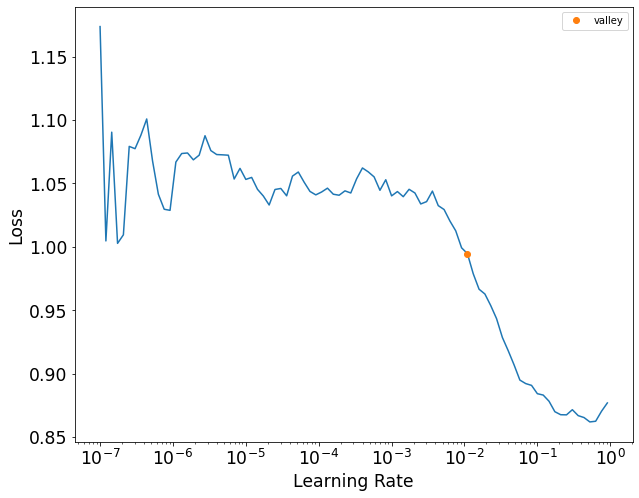

In [74]:
suggested_lr = learn.lr_find()
suggested_lr

### Training

In [75]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,0.945455,0.766780,00:00
1,0.644612,0.422244,00:00
2,0.496172,0.411279,00:00
3,0.421464,0.383860,00:00
4,0.381563,0.378475,00:00
5,0.358796,0.375551,00:00
6,0.340705,0.362119,00:00
7,0.329361,0.361454,00:00
8,0.321927,0.363134,00:00
9,0.316460,0.361538,00:00


In [76]:
# learn.val_preds, learn.val_targets #

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_training


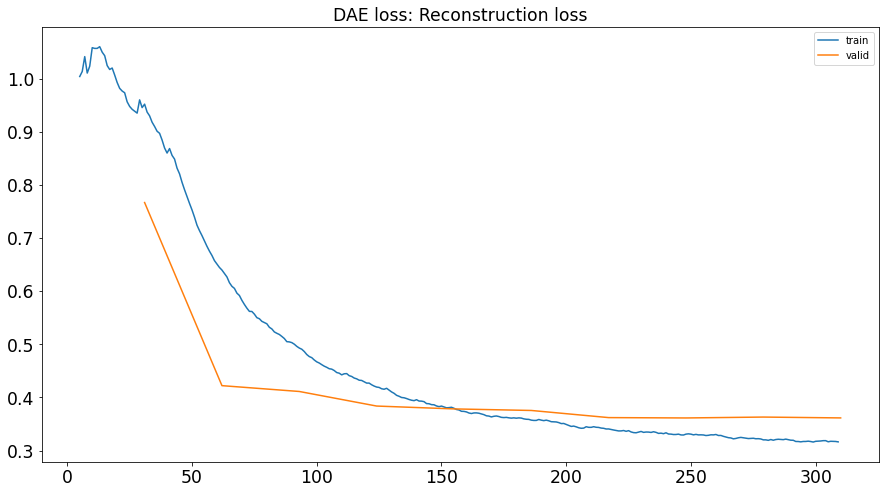

In [77]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('DAE loss: Reconstruction loss')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='dae_training',
                        folder=folder)

In [78]:
# L(zip(learn.recorder.iters, learn.recorder.values))


### Evaluation

In [79]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(4909, 4909)

MSE on transformed data is not too interesting for comparision between models if these use different standardizations

In [80]:
learn.loss_func(pred, target)  # MSE in transformed space not too interesting

TensorBase(0.3605)

In [81]:
# check target is in expected order
Y = dls.valid.targ

npt.assert_almost_equal(
    actual=target.numpy(),
    desired=Y.stack().to_numpy()
)

In [82]:
# import torch
# from fastai.tabular.core import TabularPandas

df_pred['intensity_pred_dae'] = ae.transform_preds(
    pred=pred, index=analysis.df_valid.stack().index, normalizer=tf_norm)
df_pred

intensity  \
Sample ID                           peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                        30.461   
                                    ALTSEIALLQSR                    27.244   
                                    EGNDLYHEMIESGVINLK              27.597   
                                    TLTAVHDAILEDLVFPSEIVGK          30.168   
                                    VLAMSGDPNYLHR                   27.667   
...                                                                    ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR               28.390   
                                    HIYYITGETK                      30.932   
                                    IHVSDQELQSANASVDDSRLEELK        28.929   
                                    KIEPELDGSAQVTSHDASTNGLINFIK     30.358   
                                    NMMAACDPR                       32.531   

                                                                 train_median  \
Sample ID                           peptide                                     
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                           31.743   
                                    ALTSEIALLQSR                       28.492   
                                    EGNDLYHEMIESGVINLK                 28.637   
                                    TLTAVHDAILEDLVFPSEIVGK             30.036   
                                    VLAMSGDPNYLHR                      28.729   
...                                                                       ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                  28.837   
                                    HIYYITGETK                         30.755   
                                    IHVSDQELQSANASVDDSRLEELK           28.922   
                                    KIEPELDGSAQVTSHDASTNGLINFIK        30.012   
                                    NMMAACDPR                          32.091   

                                                                 train_average  \
Sample ID                           peptide                                      
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                            31.775   
                                    ALTSEIALLQSR                        28.482   
                                    EGNDLYHEMIESGVINLK                  28.841   
                                    TLTAVHDAILEDLVFPSEIVGK              29.682   
                                    VLAMSGDPNYLHR                       28.549   
...                                                                        ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                   28.853   
                                    HIYYITGETK                          30.692   
                                    IHVSDQELQSANASVDDSRLEELK            29.252   
                                    KIEPELDGSAQVTSHDASTNGLINFIK         29.913   
                                    NMMAACDPR                           32.015   

                                                                 replicates  \
Sample ID                           peptide                                   
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                         31.118   
                                    ALTSEIALLQSR                     27.467   
                                    EGNDLYHEMIESGVINLK               27.366   
                                    TLTAVHDAILEDLVFPSEIVGK           29.769   
                                    VLAMSGDPNYLHR                    27.706   
...                                                                     ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                28.490   
                                    HIYYITGETK                       30.868   
                                    IHVSDQELQSANASVDDSRLEELK         29.313   
                                    KIEPELDGSAQVTSHDASTNGLIN

### 2D plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [83]:
latent_space = []
for b in dls.valid:
    model_input = b[1]
    latent_space.append(model.encoder(model_input).detach().numpy())

df_dae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_dae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.033,-0.076
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,0.029,-0.049
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.733,-0.766
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.594,-0.636
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,-0.241,-0.118


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_date


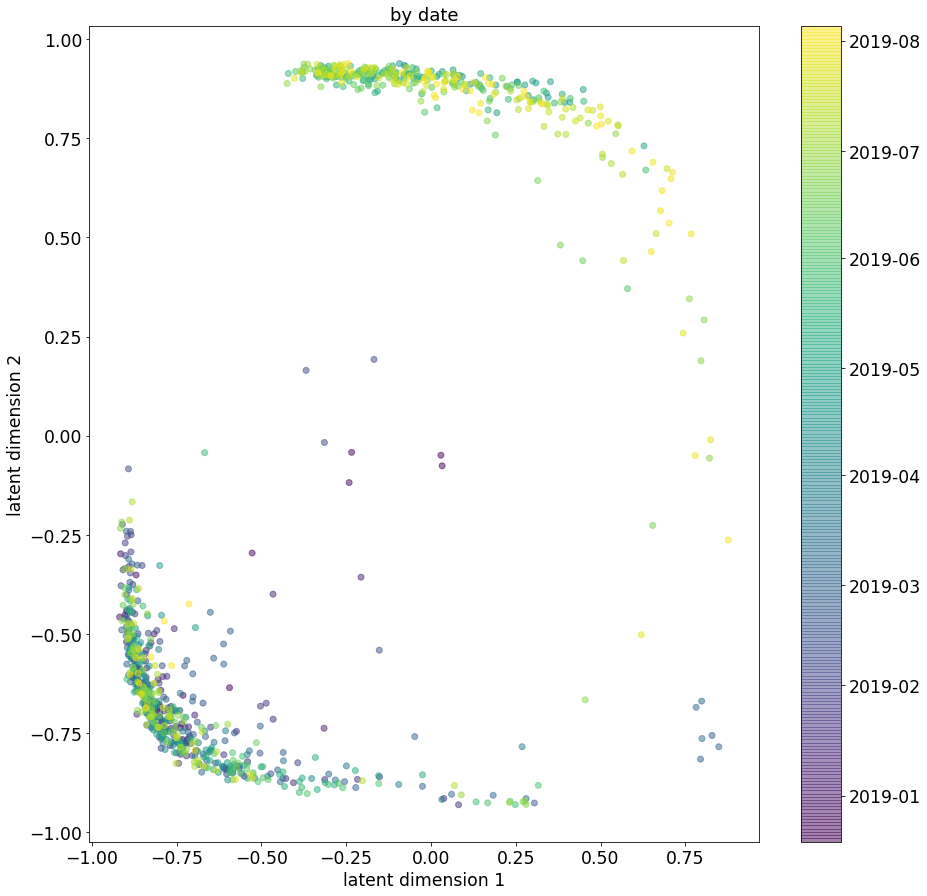

In [84]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_dae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_dae_latent.index])
vaep.io_images._savefig(fig, name='dae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\dae_latent_by_ms_instrument


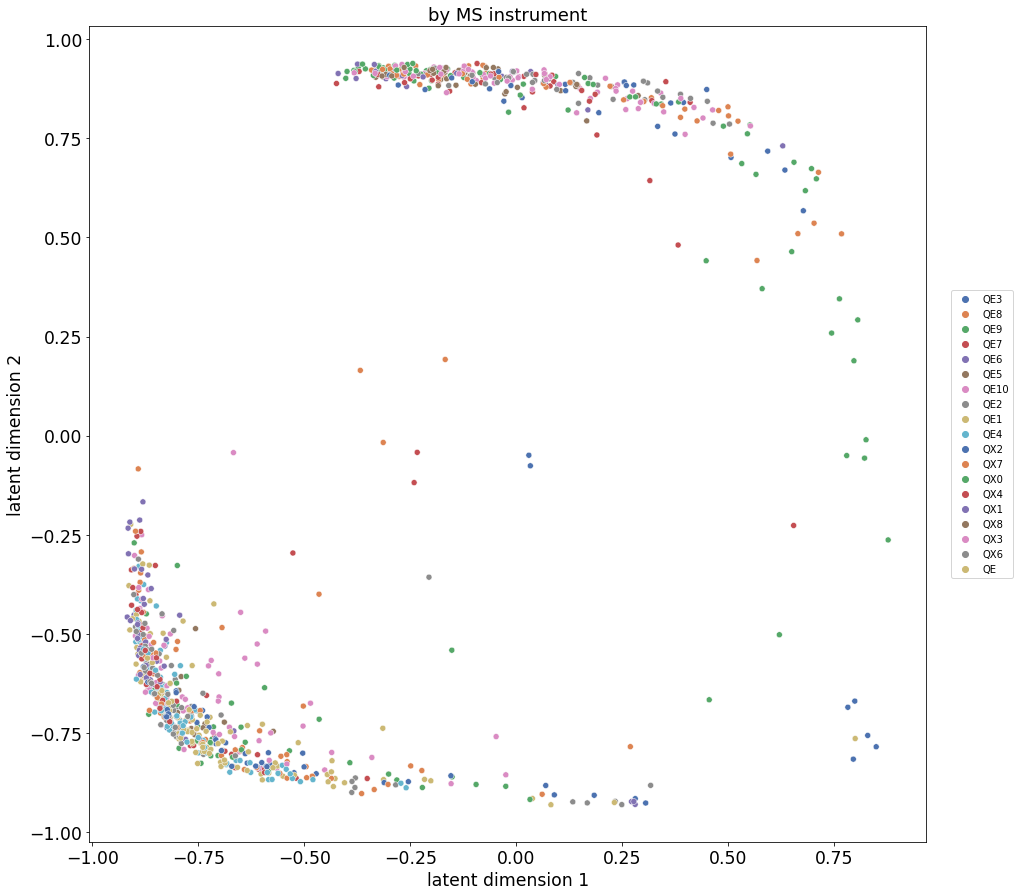

In [85]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_dae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_dae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'dae_latent_by_{meta_col}', folder=folder)

## Variational Autoencoder (VAE)

### Scikit Learn MinMaxScaler

- [docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [86]:
from vaep.transform import MinMaxScaler

args_vae = {}
args_vae['SCALER'] = MinMaxScaler
# select initial data: transformed vs not log transformed
scaler = args_vae['SCALER']().fit(analysis.df_train)
scaler.transform(analysis.df_valid.iloc[:5])

peptide,ADEGISFR,AFGYYGPLR,AHGPGLEGGLVGKPAEFTIDTK,AIDDNMSLDEIEK,ALTSEIALLQSR,AQIHDLVLVGGSTR,ARFEELCSDLFR,DSTLIMQLLR,EEASDYLELDTIK,EGHLSPDIVAEQK,...,TFVNITPAEVGVLVGK,THEAQIQEMR,TLTAVHDAILEDLVFPSEIVGK,TVAGGAWTYNTTSAVTVK,VEFMDDTSR,VEPGLGADNSVVR,VFITDDFHDMMPK,VLAMSGDPNYLHR,VVSQYSSLLSPMSVNAVMK,YMACCLLYR
Sample ID,,,,,,,,,,,,,,,,,,,,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,0.617,NaN,NaN,NaN,0.498,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.715,NaN,NaN,NaN,NaN,0.630,NaN,NaN
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,NaN,0.571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.671
20181221_QE8_nLC0_NHS_MNT_HeLa_01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181222_QE9_nLC9_QC_50CM_HeLa1,NaN,NaN,NaN,0.653,0.524,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,NaN,NaN,NaN,NaN,0.520,0.620,NaN,NaN,0.679,NaN,...,NaN,NaN,NaN,NaN,NaN,0.732,NaN,NaN,NaN,NaN


### DataLoaders

- follow instructions for using plain PyTorch Datasets, see [tutorial](https://docs.fast.ai/tutorial.siamese.html#Preparing-the-data)


In [87]:
assert all(analysis.df_train.columns == analysis.df_valid.columns)
if not all(analysis.df.columns == analysis.df_train.columns):
    print("analysis.df columns are not the same as analysis.df_train")
    # ToDo: DataLoading has to be cleaned up
    # analysis.df = analysis.df_train.fillna(analysis.df_valid)

analysis.df columns are not the same as analysis.df_train


In [88]:
from vaep.io.datasets import PeptideDatasetInMemory

FILL_NA = 0.0

train_ds = PeptideDatasetInMemory(data=scaler.transform(
    analysis.df_train).to_numpy(dtype=None), fill_na=FILL_NA)
valid_ds = PeptideDatasetInMemory(data=scaler.transform(analysis.df_train.fillna(analysis.df_valid)).to_numpy(dtype=None),
                                  mask=analysis.df_valid.notna().to_numpy(), fill_na=FILL_NA)

assert (train_ds.peptides == valid_ds.peptides).all()

In [89]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, n_inp=2)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


### Model

In [90]:
from torch.nn import Sigmoid

M = analysis.df_train.shape[-1]
model = ae.VAE(n_features=M, n_neurons=int(
    M/2), last_encoder_activation=None, last_decoder_activation=Sigmoid, dim_latent=latent_dim)

### Learner

In [91]:
learn = Learner(dls=dls,
                model=model,
                loss_func=ae.loss_fct_vae,
                cbs=ae.ModelAdapterVAE())

learn.show_training_loop()
learn.summary()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [ModelAdapterVAE]
         - after_pred     : [ModelAdapterVAE]
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback

VAE (Input shape: 64 x 50)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 25             
Linear                                    75         True      
Tanh                                                           
____________________________________________________________________________
                     64 x 50             
Linear                                    1300       True      
Sigmoid                                                        
____________________________________________________________________________
                     64 x 25             
Linear                                    1275       True      
Tanh                                                           
____________________________________________________________________________
                     64 x 4              
Linear                                    104        True      
______________________________________________________________

### Training

SuggestedLRs(valley=0.0030199517495930195)

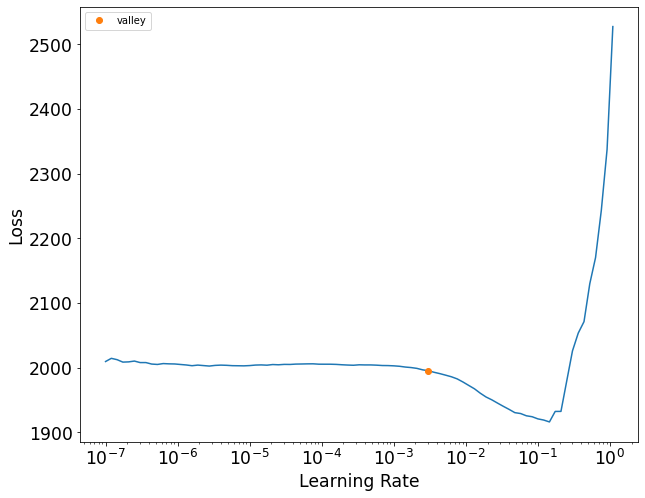

In [92]:
suggested_lr = learn.lr_find()
suggested_lr

In [93]:
learn.fit_one_cycle(epochs_max, lr_max=suggested_lr.valley)

epoch,train_loss,valid_loss,time
0,1994.865479,218.006882,00:00
1,1959.040894,213.487366,00:00
2,1894.172363,215.847855,00:00
3,1840.316040,209.491745,00:00
4,1804.649292,200.816116,00:00
5,1779.109497,202.638031,00:00
6,1762.020020,199.662079,00:00
7,1749.379639,197.001617,00:00
8,1739.365479,197.190643,00:00
9,1732.340454,197.389496,00:00


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_training


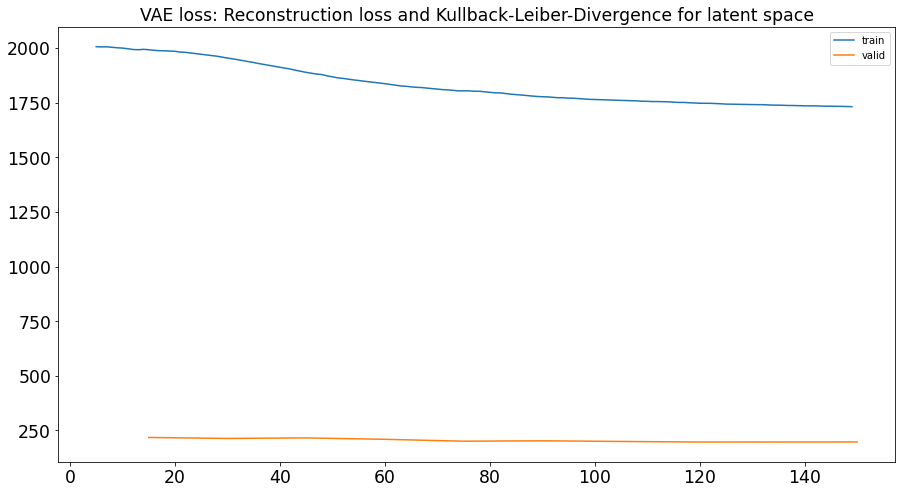

In [94]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title('VAE loss: Reconstruction loss and Kullback-Leiber-Divergence for latent space')
learn.recorder.plot_loss(skip_start=5, ax=ax)
vaep.io_images._savefig(fig, name='vae_training',
                        folder=folder)

### Evaluation

In [95]:
# reorder True: Only 500 predictions returned
pred, target = learn.get_preds(act=noop, concat_dim=0, reorder=False)
len(pred), len(target)

(3, 4909)

In [96]:
len(pred[0])

4909

In [97]:
learn.loss_func(pred, target)

tensor(3110.6082)

In [98]:
_pred = pd.Series(pred[0], index=analysis.df_valid.stack().index).unstack()
_pred = scaler.inverse_transform(_pred).stack()

df_pred['intensity_pred_vae'] = _pred
df_pred

intensity  \
Sample ID                           peptide                                  
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                        30.461   
                                    ALTSEIALLQSR                    27.244   
                                    EGNDLYHEMIESGVINLK              27.597   
                                    TLTAVHDAILEDLVFPSEIVGK          30.168   
                                    VLAMSGDPNYLHR                   27.667   
...                                                                    ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR               28.390   
                                    HIYYITGETK                      30.932   
                                    IHVSDQELQSANASVDDSRLEELK        28.929   
                                    KIEPELDGSAQVTSHDASTNGLINFIK     30.358   
                                    NMMAACDPR                       32.531   

                                                                 train_median  \
Sample ID                           peptide                                     
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                           31.743   
                                    ALTSEIALLQSR                       28.492   
                                    EGNDLYHEMIESGVINLK                 28.637   
                                    TLTAVHDAILEDLVFPSEIVGK             30.036   
                                    VLAMSGDPNYLHR                      28.729   
...                                                                       ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                  28.837   
                                    HIYYITGETK                         30.755   
                                    IHVSDQELQSANASVDDSRLEELK           28.922   
                                    KIEPELDGSAQVTSHDASTNGLINFIK        30.012   
                                    NMMAACDPR                          32.091   

                                                                 train_average  \
Sample ID                           peptide                                      
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                            31.775   
                                    ALTSEIALLQSR                        28.482   
                                    EGNDLYHEMIESGVINLK                  28.841   
                                    TLTAVHDAILEDLVFPSEIVGK              29.682   
                                    VLAMSGDPNYLHR                       28.549   
...                                                                        ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                   28.853   
                                    HIYYITGETK                          30.692   
                                    IHVSDQELQSANASVDDSRLEELK            29.252   
                                    KIEPELDGSAQVTSHDASTNGLINFIK         29.913   
                                    NMMAACDPR                           32.015   

                                                                 replicates  \
Sample ID                           peptide                                   
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02 ADEGISFR                         31.118   
                                    ALTSEIALLQSR                     27.467   
                                    EGNDLYHEMIESGVINLK               27.366   
                                    TLTAVHDAILEDLVFPSEIVGK           29.769   
                                    VLAMSGDPNYLHR                    27.706   
...                                                                     ...   
20190805_QE1_nLC2_AB_MNT_HELA_04    FVINYDYPNSSEDYIHR                28.490   
                                    HIYYITGETK                       30.868   
                                    IHVSDQELQSANASVDDSRLEELK         29.313   
                                    KIEPELDGSAQVTSHDASTNGLIN

### Add plot of latent space

- 2 dimensional latent space: just plot
- more than 2 dimensional: PCA, etc

In [99]:
latent_space = []
for b in dls.valid:
    model_input = b[0]
    b_mu, b_std = model.get_mu_and_logvar(model_input, detach=True)
    latent_space.append(b_mu)


df_vae_latent = build_df_from_pred_batches(latent_space,
                                           index=_df_valid.items.index,
                                           columns=[f'latent dimension {i+1}' for i in range(latent_dim)])
df_vae_latent.head()

,latent dimension 1,latent dimension 2
Sample ID,,
20181219_QE3_nLC3_DS_QC_MNT_HeLa_02,-0.071,0.138
20181219_QE3_nLC3_TSB_QC_MNT_HeLa_01,-0.040,0.038
20181221_QE8_nLC0_NHS_MNT_HeLa_01,-0.024,0.088
20181222_QE9_nLC9_QC_50CM_HeLa1,-0.070,0.017
20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01,0.047,0.167


vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_date


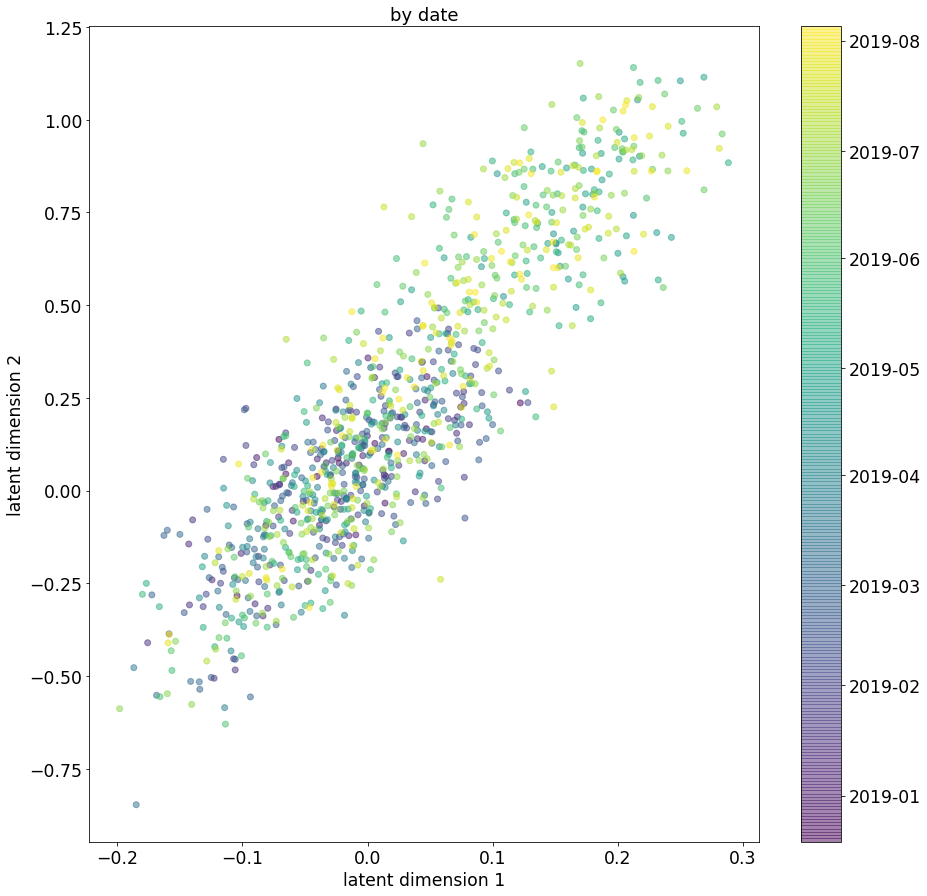

In [100]:
fig, ax = plt.subplots(figsize=(15, 15))
analyzers.plot_date_map(df=df_vae_latent, fig=fig, ax=ax,
                        dates=analysis.df_meta.date.loc[df_vae_latent.index])
vaep.io_images._savefig(fig, name='vae_latent_by_date',
                        folder=folder)

vaep.io_images - INFO     Saved Figures to runs\2D\feat_0050_epochs_010\vae_latent_by_ms_instrument


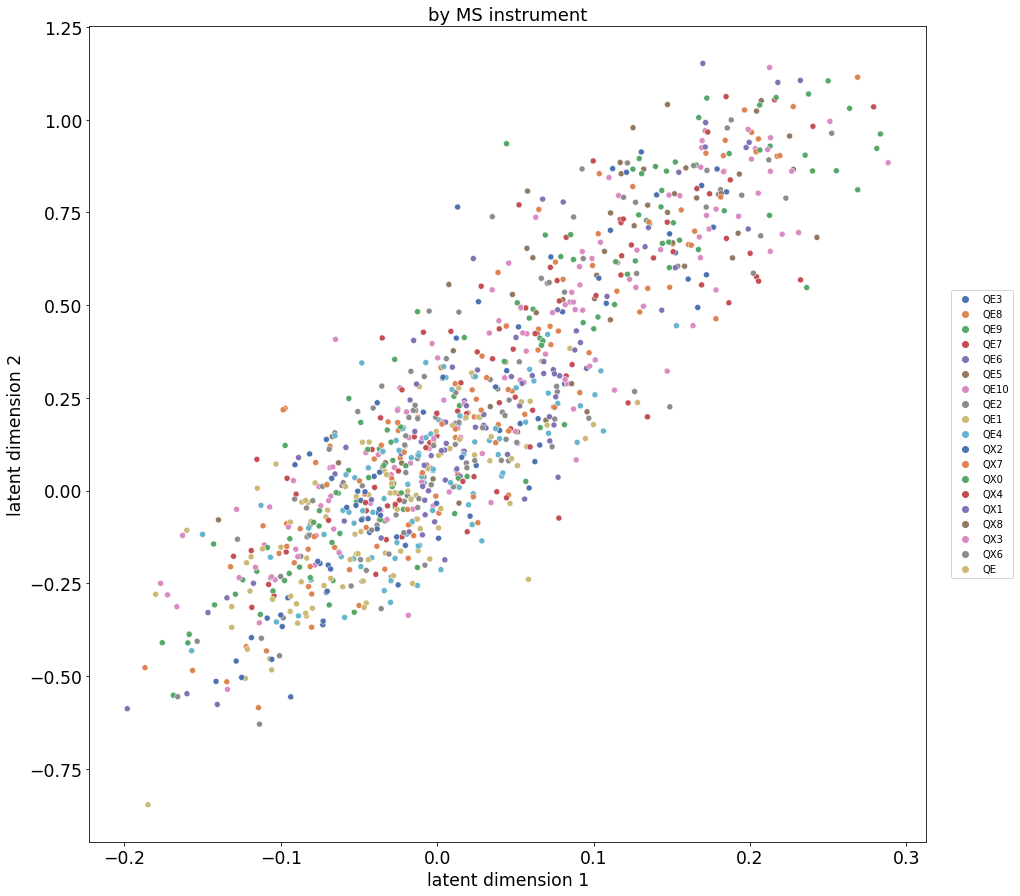

In [101]:
fig, ax = plt.subplots(figsize=(15, 15))

meta_col = 'ms_instrument'

analyzers.seaborn_scatter(df=df_vae_latent,
                          fig=fig,
                          ax=ax,
                          meta=analysis.df_meta[meta_col].loc[df_vae_latent.index],
                          title='by MS instrument')

vaep.io_images._savefig(
    fig, name=f'vae_latent_by_{meta_col}', folder=folder)

## Compare the 3 models

- replicates: replace NAs with neighbouring ("close") values
- train average, median: Replace NA with average or median from training data

In [102]:
import sklearn.metrics as sklm
pred_columns = df_pred.columns[1:]
scoring = [('MSE', sklm.mean_squared_error),
           ('MAE', sklm.mean_absolute_error)]

y_true = df_pred['intensity']

metrics = {}
for col in pred_columns:
    _y_pred = df_pred[col].dropna()
    if len(df_pred[col]) > len(_y_pred):
        logger.info(
            f"Drop indices for {col}: {[(idx[0], idx[1]) for idx in df_pred[col].index.difference(_y_pred.index)]}")

    metrics[col] = dict(
        [(k, f(y_true=y_true.loc[_y_pred.index], y_pred=_y_pred))
         for k, f in scoring]
    )

metrics = pd.DataFrame(metrics)
metrics.to_csv(folder / f'exp_02_metrics.csv',
               float_format='{:.3f}'.format)
metrics.sort_values(by=[k for k, f in scoring], axis=1)

vaep - INFO     Drop indices for replicates: [('20181223_QE7_nLC7_RJC_MEM_MNT_HeLa_01', 'ALTSEIALLQSR'), ('20181227_QE6_nLC6_CSC_QC_HeLa_02', 'SGDSEVYQLGDVSQK'), ('20181228_QE5_nLC5_OOE_QC_MNT_HELA_15cm_250ng_RO-007', 'ELAEDGYSGVEVR'), ('20190115_QE2_NLC10_TW_QC_MNT_HeLa_01', 'ITLQDVVSHSK'), ('20190115_QE5_nLC5_RJC_MNT_HeLa_01', 'YMACCLLYR'), ('20190129_QE1_nLC2_GP_QC_MNT_HELA_01', 'EQIVPKPEEEVAQK'), ('20190131_QE10_nLC0_NHS_MNT_HELA_50cm_02', 'FAQPGSFEYEYAMR'), ('20190201_QE10_nLC0_NHS_MNT_HELA_45cm_01', 'FLSQPFQVAEVFTGHMGK'), ('20190203_QE3_nLC3_KBE_QC_MNT_HeLa_01', 'GYISPYFINTSK'), ('20190204_QE6_nLC6_MPL_QC_MNT_HeLa_04', 'TAFQEALDAAGDK'), ('20190207_QE2_NLC10_GP_MNT_HeLa_01', 'AFGYYGPLR'), ('20190214_QE4_LC12_SCL_QC_MNT_HeLa_03', 'DSTLIMQLLR'), ('20190219_QE3_Evo2_UHG_QC_MNT_HELA_01_190219173213', 'MELQEIQLK'), ('20190225_QE10_PhGe_Evosep_88min_HeLa_5', 'AIDDNMSLDEIEK'), ('20190226_QE10_PhGe_Evosep_88min-30cmCol-HeLa_14_27', 'VVSQYSSLLSPMSVNAVMK'), ('20190226_QE10_PhGe_Evosep_88min

,intensity_pred_collab,intensity_pred_dae,intensity_pred_vae,replicates,train_average,train_median
MSE,0.649,0.683,1.691,1.740,2.031,2.095
MAE,0.483,0.502,0.949,0.897,1.056,1.040


Save final prediction values of validation data for later comparison.

In [103]:
df_pred.to_csv(folder /
               f"{config.FOLDER_DATA}_valid_pred.csv")

## PCA plot for imputed and denoised data

two setups:
 - impute missing values
 - additinally change observed values